# 2.1 Model training and cross validation

Notebook structure:
1. Preparation of training and test data
2. Finalize training data and split for cross validation
3. Finalize test dataset 
4. **Model trained on cluster using train_custom_loss.py**
5. Model validation

In [10]:
# Import libraries
import joblib
import numpy as np
import pandas as pd
import xgboost as xgb
from matplotlib import pyplot as plt
from tqdm import tqdm
from itertools import product
import dill as pickle

from sklearn.model_selection import KFold
from sklearn.model_selection import GroupKFold
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import BaseCrossValidator
from sklearn.inspection import permutation_importance
from sklearn.utils.validation import check_is_fitted

from scripts.model_classes import CustomXGBRegressor

from scripts.helpers import reshape_dataset_monthly
from scripts.helpers import get_ytrue_y_pred_agg
from scripts.helpers import get_ytrue_y_pred_agg_season
from scripts.helpers import get_prediction_per_season
from scripts.helpers import get_prediction_per_season_test

from scripts.data_processing import get_ann_seas_train_test_datasets
from scripts.data_processing import prepare_features

from scripts.plotting_functions import plot_train_val_counts
from scripts.plotting_functions import plot_feature_distributions
from scripts.plotting_functions import plot_gsearch_results
from scripts.plotting_functions import plot_gsearch_results_mod
from scripts.plotting_functions import plot_prediction
from scripts.plotting_functions import plot_prediction_subplot
from scripts.plotting_functions import plot_prediction_per_season
from scripts.plotting_functions import plot_feature_importance
from scripts.plotting_functions import plot_permutation_importance_per_fold


## 1 Prepare training and test data

In [11]:
# Specify filepaths and filenames         
loc = 'local'

if loc == 'cryocloud':
    filepath = '/home/jovyan/ML_MB_Norway_data/'
elif loc == 'local':
    filepath = 'Data/'

filename = '2023-08-28_stake_mb_norway_cleaned_ids_latlon_wattributes_climate_svf.csv'

# Load data
data = pd.read_csv(filepath + filename)

# Define test glaciers
test_glaciers = [54, 703, 941, 1135, 1280, 2085, 2320, 2478, 2768, 2769, 3133, 3137, 3138, 3141]
# 54 has 189 points
# 703 has 30 points
# 941 has 70 points
# 1280 has 71 points
# 2320 has 83 points
# 2478 has 89 points
# 2769 has 121 points
# 3133 has 38 points
# 3137 has 65 points
# 3138 has 6 points
# 3141 has 72 points

# Get train and test datasets
datasets_train, datasets_test = get_ann_seas_train_test_datasets(data, test_glaciers)


Train/test annual: 2845/1065
Train/test winter: 2752/1000
Train/test summer: 2901/1028
All train/test: 8498 / 3093
Fraction train/test: 0.7331550340781641 / 0.26684496592183593
Total entries: 11591


C:\Users\kasj\AppData\Local\Temp\ipykernel_26100\4140151468.py:12: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(filepath + filename)


In [12]:
df_train_annual = datasets_train['train_annual']
df_train_winter = datasets_train['train_winter']
df_train_summer = datasets_train['train_summer']
df_test_annual = datasets_test['test_annual']
df_test_winter = datasets_test['test_winter']
df_test_summer = datasets_test['test_summer']

# Remove strange value
df_test_winter = df_test_winter[df_test_winter['balance_winter'] != 9.99].reset_index(drop=True)

df_test_winter

,RGIID,GLIMSID,BREID,utm_zone,utm_east_approx,utm_north_approx,altitude_approx,location_description,location_id,stake_no,...,tp_apr,tp_may,tp_jun,tp_jul,tp_aug,tp_sep,altitude_climate,skyview_factor,year,n_months
0,RGI60-08.01258,G021737E70130N,54,34,529400.0,7780050.0,500.0,Nederst på bretunga,L10,L1012,...,0.002334,0.001159,0.003054,0.003977,0.004691,0.001449,341.227919,0.778997,2013,7
1,RGI60-08.01258,G021737E70130N,54,34,529400.0,7780050.0,500.0,Nederst på bretunga,L10,L1013,...,0.005634,0.002244,0.003412,0.000891,0.002129,0.004860,341.227919,0.798494,2014,7
2,RGI60-08.01258,G021737E70130N,54,34,529400.0,7780050.0,500.0,Nederst på bretunga,L10,L1013,...,0.003739,0.004709,0.005111,0.001253,0.002506,0.003256,341.227919,0.803510,2015,7
3,RGI60-08.01258,G021737E70130N,54,34,529400.0,7780050.0,500.0,Nederst på bretunga,L10,L1013,...,0.001256,0.002129,0.003969,0.003559,0.002119,0.002851,341.227919,0.803510,2016,7
4,RGI60-08.01258,G021737E70130N,54,34,529400.0,7780050.0,500.0,Nederst på bretunga,L10,L1016,...,0.002704,0.003991,0.001780,0.004257,0.005193,0.000710,341.227919,0.817480,2017,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
994,RGI60-08.02969,G006362E59989N,3141,32,351800.0,6647500.0,1080.0,Nederst på bretunga,B15,B1509,...,0.003555,0.005019,0.004730,0.007226,0.005739,0.011397,917.419759,0.932281,2012,7
995,RGI60-08.02969,G006362E59989N,3141,32,351800.0,6647500.0,1080.0,Nederst på bretunga,B15,B1509,...,0.009360,0.006135,0.006760,0.005158,0.008218,0.005461,917.419759,0.932281,2013,7
996,RGI60-08.02969,G006362E59989N,3141,32,351800.0,6647500.0,1080.0,Nederst på bretunga,B15,B1514,...,0.006261,0.008175,0.005974,0.006563,0.008015,0.003896,917.419759,0.932281,2015,7
997,RGI60-08.02969,G006362E59989N,3141,32,351800.0,6647500.0,1080.0,Nederst på bretunga,B15,B1514,...,0.004573,0.004449,0.005235,0.008926,0.011151,0.009556,917.419759,0.932281,2016,7


In [13]:
# Select features
id_vars_ext = ['BREID', 'year', 'altitude', 'altitude_climate', 'balance_netto', 'balance_summer', 'balance_winter','aspect','slope','skyview_factor','n_months']
# To save monthly training dataset:
#id_vars_ext = ['BREID', 'RGIID', 'year', 'altitude', 'altitude_climate', 'balance_netto', 'balance_summer', 'balance_winter','aspect','slope','skyview_factor','n_months']

# Includes RGIID for model comparison
id_vars_ext_test = ['BREID', 'RGIID', 'year', 'altitude', 'altitude_climate', 'balance_netto', 'balance_summer', 'balance_winter','aspect','slope','skyview_factor','n_months']
climate_vars = ['t2m_', 'sshf_', 'slhf_', 'ssrd_', 'fal_','str_', 'tp_']

# Get features for datasets
df_train_annual_clean = prepare_features(df_train_annual, 'annual', id_vars_ext, climate_vars)
df_train_winter_clean = prepare_features(df_train_winter, 'winter', id_vars_ext, climate_vars)
df_train_summer_clean = prepare_features(df_train_summer, 'summer', id_vars_ext, climate_vars)

df_test_annual_clean = prepare_features(df_test_annual, 'annual', id_vars_ext_test, climate_vars, drop_altitude=False)
df_test_winter_clean = prepare_features(df_test_winter, 'winter', id_vars_ext_test, climate_vars, drop_altitude=False)
df_test_summer_clean = prepare_features(df_test_summer, 'summer', id_vars_ext_test, climate_vars, drop_altitude=False)


In [14]:
df_train_annual_clean

,RGIID,BREID,balance,aspect,slope,t2m_oct,t2m_nov,t2m_dec,t2m_jan,t2m_feb,...,tp_apr,tp_may,tp_jun,tp_jul,tp_aug,tp_sep,skyview_factor,year,n_months,altitude_diff
189,RGI60-08.02436,596,-1.76,2.509464,0.238202,269.201416,264.435547,258.228821,258.308533,257.074158,...,0.003016,0.001702,0.001953,0.004025,0.002591,0.006047,0.883281,1963,12,11.181943
190,RGI60-08.02436,596,-0.30,2.474161,0.117946,269.387421,261.827911,262.573364,265.326019,260.279266,...,0.001993,0.002906,0.003402,0.003066,0.004062,0.004951,0.957209,1964,12,5.181943
191,RGI60-08.02436,596,-2.18,2.509464,0.238202,270.417572,259.927002,254.755005,255.577148,252.211121,...,0.001900,0.003094,0.001567,0.003896,0.004033,0.004845,0.883281,1966,12,13.181943
192,RGI60-08.02436,596,-1.68,2.478294,0.146882,267.011292,265.178741,258.606110,257.204742,261.810455,...,0.003376,0.000861,0.004021,0.006549,0.003302,0.003687,0.960949,1967,12,11.181943
193,RGI60-08.02436,596,-0.31,2.478294,0.146882,267.775757,267.829651,256.208740,254.525742,259.089691,...,0.004694,0.001514,0.004824,0.003683,0.004470,0.001097,0.960949,1968,12,11.181943
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3724,RGI60-08.02643,3129,0.90,2.115165,0.111223,273.632507,271.576019,266.273407,264.191864,263.937561,...,0.002380,0.003067,0.004948,0.001373,0.001677,0.008620,0.953703,1968,12,-556.166788
3725,RGI60-08.02643,3129,0.91,2.312361,0.097301,273.717529,268.352692,263.543549,266.749390,264.269287,...,0.005509,0.005468,0.009837,0.010945,0.007251,0.008933,0.969350,1964,12,-576.166788
3726,RGI60-08.02643,3129,0.19,2.482095,0.070551,272.888550,269.671326,264.862183,262.965088,264.204773,...,0.002511,0.001531,0.006192,0.002394,0.006272,0.007284,0.966856,1965,12,-592.166788
3727,RGI60-08.02643,3129,-1.11,2.339748,0.073072,276.245483,262.063232,260.118317,258.969757,258.766296,...,0.002017,0.004337,0.003802,0.004859,0.004397,0.011932,0.968909,1966,12,-595.166788


In [15]:
df_test_summer_clean

,RGIID,BREID,altitude,balance,aspect,slope,t2m_may,t2m_jun,t2m_jul,t2m_aug,...,tp_may,tp_jun,tp_jul,tp_aug,tp_sep,altitude_climate,skyview_factor,year,n_months,altitude_diff
0,RGI60-08.01258,54,471.0,-6.24,0.629597,0.278773,277.677979,283.339630,283.829285,283.778412,...,0.001159,0.003054,0.003977,0.004691,0.001449,341.227919,0.778997,2013,5,-129.772081
1,RGI60-08.01258,54,439.0,-4.35,0.585924,0.296590,273.853424,278.533508,286.991089,283.409485,...,0.002244,0.003412,0.000891,0.002129,0.004860,341.227919,0.798494,2014,5,-97.772081
2,RGI60-08.01258,54,444.0,-4.17,0.663261,0.302508,275.326904,277.934570,282.700439,284.425964,...,0.004709,0.005111,0.001253,0.002506,0.003256,341.227919,0.803510,2015,5,-102.772081
3,RGI60-08.01258,54,444.0,-4.37,0.663261,0.302508,277.405426,279.781555,284.442657,282.017212,...,0.002129,0.003969,0.003559,0.002119,0.002851,341.227919,0.803510,2016,5,-102.772081
4,RGI60-08.01258,54,468.0,-4.05,0.836757,0.309196,272.579590,278.621582,283.518036,282.460541,...,0.003991,0.001780,0.004257,0.005193,0.000710,341.227919,0.817480,2017,5,-126.772081
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3924,RGI60-08.02969,3141,1078.0,-3.57,2.906044,0.131717,276.051880,279.342010,282.147797,282.897827,...,0.005019,0.004730,0.007226,0.005739,0.011397,917.419759,0.932281,2012,5,-160.580241
3925,RGI60-08.02969,3141,1078.0,-4.29,2.906044,0.131717,277.164032,280.542206,284.284760,282.710297,...,0.006135,0.006760,0.005158,0.008218,0.005461,917.419759,0.932281,2013,5,-160.580241
3926,RGI60-08.02969,3141,1079.0,-3.80,2.906044,0.131717,274.069031,278.133453,281.378021,283.121002,...,0.008175,0.005974,0.006563,0.008015,0.003896,917.419759,0.932281,2015,5,-161.580241
3927,RGI60-08.02969,3141,1078.0,-4.38,2.906044,0.131717,278.187347,283.209045,282.545563,282.466614,...,0.004449,0.005235,0.008926,0.011151,0.009556,917.419759,0.932281,2016,5,-160.580241


In [16]:
# Finalize training data

# Assign Ids for each target
n_summer = len(df_train_summer_clean)
n_winter = len(df_train_winter_clean)
n_annual = len(df_train_annual_clean)

df_train_summer_clean.insert(0, 'id', list(range(n_summer)))
df_train_winter_clean.insert(0, 'id', list(range(n_summer, n_summer+n_winter)))
df_train_annual_clean.insert(0, 'id', list(range(n_summer+n_winter, n_summer+n_winter+n_annual)))

# Order of months
summer_months_order = ['may', 'jun', 'jul', 'aug', 'sep']
winter_months_order = ['oct','nov','dec','jan','feb','mar','apr']#,'may']
annual_months_order = ['oct','nov','dec','jan','feb','mar','apr', 'may', 'jun', 'jul', 'aug', 'sep']

id_vars = ['id','BREID', 'year', 'altitude_diff','balance','aspect','slope','skyview_factor','n_months']
# To save monthly training dataset:
#id_vars = ['id','BREID', 'RGIID','year', 'altitude_diff','balance','aspect','slope','skyview_factor','n_months']

variables = ['t2m', 'sshf', 'slhf', 'ssrd', 'fal','str', 'tp']

# Reshape dataframes to monthly resolution
df_train_summer_final = reshape_dataset_monthly(df_train_summer_clean, id_vars, variables, summer_months_order)
df_train_winter_final = reshape_dataset_monthly(df_train_winter_clean, id_vars, variables, winter_months_order)
df_train_annual_final = reshape_dataset_monthly(df_train_annual_clean, id_vars, variables, annual_months_order)

# Combine training data in one dataframe
df_train_summer_final.reset_index(drop=True, inplace=True)
df_train_winter_final.reset_index(drop=True, inplace=True)
df_train_annual_final.reset_index(drop=True, inplace=True)

data_list = [df_train_summer_final, df_train_winter_final, df_train_annual_final]
df_train_final = pd.concat(data_list)

df_train_final.reset_index(drop=True, inplace=True)

check_nan = df_train_final.isna().values.sum()
if check_nan != 0:
    print(check_nan)

# 67909 x 17 for all data
df_train_final

,id,BREID,RGIID,year,altitude_diff,balance,aspect,slope,skyview_factor,n_months,month,t2m,sshf,slhf,ssrd,fal,str,tp
0,0,596,RGI60-08.02436,1963,11.181943,-3.41,2.509464,0.238202,0.883281,5,may,274.658875,1.493194e+04,-375995.0,18766128.0,0.596335,-2832247.00,0.001702
1,0,596,RGI60-08.02436,1963,11.181943,-3.41,2.509464,0.238202,0.883281,5,jun,274.336243,-1.636112e+05,-521774.5,21166500.0,0.613368,-2748427.50,0.001953
2,0,596,RGI60-08.02436,1963,11.181943,-3.41,2.509464,0.238202,0.883281,5,jul,277.882172,-1.717710e+06,-2857569.5,15175713.0,0.282537,-3019285.50,0.004025
3,0,596,RGI60-08.02436,1963,11.181943,-3.41,2.509464,0.238202,0.883281,5,aug,281.432678,-1.826724e+06,-3644167.5,11799862.0,0.123184,-4122848.50,0.002591
4,0,596,RGI60-08.02436,1963,11.181943,-3.41,2.509464,0.238202,0.883281,5,sep,276.588593,-4.764911e+05,-1239184.5,6023235.0,0.295263,-2144487.50,0.006047
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67904,8497,3129,RGI60-08.02643,1967,-592.166788,1.58,2.526225,0.068208,0.971815,12,may,274.327118,-9.279995e+05,-247320.5,17505508.0,0.618479,-2179443.00,0.004908
67905,8497,3129,RGI60-08.02643,1967,-592.166788,1.58,2.526225,0.068208,0.971815,12,jun,277.050171,-8.421614e+05,101172.0,20268490.0,0.551025,-2504472.50,0.007480
67906,8497,3129,RGI60-08.02643,1967,-592.166788,1.58,2.526225,0.068208,0.971815,12,jul,278.294403,-4.923712e+05,282694.5,15490057.0,0.481296,-862670.75,0.006605
67907,8497,3129,RGI60-08.02643,1967,-592.166788,1.58,2.526225,0.068208,0.971815,12,aug,280.939240,-1.117702e+06,-2140415.0,12475600.0,0.284415,-2001555.00,0.006391


In [17]:
# Save training dataset
#filename_train_monthly = '2023-08-28_stake_mb_norway_cleaned_ids_latlon_wattributes_climate_svf_monthly.csv'
#df_train_final.to_csv(filepath+filename_train_monthly)

In [17]:
# Finalize test data

n_summer = len(df_test_summer_clean)
n_winter = len(df_test_winter_clean)
n_annual = len(df_test_annual_clean)

df_test_summer_clean.insert(0, 'id', list(range(n_summer)))
df_test_winter_clean.insert(0, 'id', list(range(n_summer, n_summer+n_winter)))
df_test_annual_clean.insert(0, 'id', list(range(n_summer+n_winter, n_summer+n_winter+n_annual)))

id_vars_test = ['id','BREID', 'RGIID', 'altitude', 'altitude_climate', 'year', 'altitude_diff','balance','aspect','slope','skyview_factor','n_months']
variables = ['t2m', 'sshf', 'slhf', 'ssrd', 'fal','str', 'tp']

# Reshape datasets to monthly resolution
df_test_summer_final = reshape_dataset_monthly(df_test_summer_clean, id_vars_test, variables, summer_months_order)
df_test_winter_final = reshape_dataset_monthly(df_test_winter_clean, id_vars_test, variables, winter_months_order)
df_test_annual_final = reshape_dataset_monthly(df_test_annual_clean, id_vars_test, variables, annual_months_order)

# Combine training data in one dataframe
df_test_summer_final.reset_index(drop=True, inplace=True)
df_test_winter_final.reset_index(drop=True, inplace=True)
df_test_annual_final.reset_index(drop=True, inplace=True)

data_list = [df_test_summer_final, df_test_winter_final, df_test_annual_final]
df_test_final = pd.concat(data_list)

df_test_final.reset_index(drop=True, inplace=True)

# 24913 x 20
df_test_final

,id,BREID,RGIID,altitude,altitude_climate,year,altitude_diff,balance,aspect,slope,skyview_factor,n_months,month,t2m,sshf,slhf,ssrd,fal,str,tp
0,0,54,RGI60-08.01258,471.0,341.227919,2013,-129.772081,-6.24,0.629597,0.278773,0.778997,5,may,277.677979,4.286715e+05,-237874.5,20979516.0,0.580414,-3367191.50,0.001159
1,0,54,RGI60-08.01258,471.0,341.227919,2013,-129.772081,-6.24,0.629597,0.278773,0.778997,5,jun,283.339630,-2.133166e+06,-4024573.5,17728592.0,0.198752,-3994740.00,0.003054
2,0,54,RGI60-08.01258,471.0,341.227919,2013,-129.772081,-6.24,0.629597,0.278773,0.778997,5,jul,283.829285,-2.731458e+06,-5184939.5,15538729.0,0.131911,-4661453.00,0.003977
3,0,54,RGI60-08.01258,471.0,341.227919,2013,-129.772081,-6.24,0.629597,0.278773,0.778997,5,aug,283.778412,-1.295387e+06,-3545874.5,10510849.0,0.130799,-4018348.50,0.004691
4,0,54,RGI60-08.01258,471.0,341.227919,2013,-129.772081,-6.24,0.629597,0.278773,0.778997,5,sep,280.982513,9.352438e+03,-1756179.5,6908671.0,0.130148,-4441106.50,0.001449
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24908,3091,3141,RGI60-08.02969,1078.0,917.419759,2017,-160.580241,-3.29,2.906044,0.131717,0.932281,12,may,277.690887,-5.189375e+02,-71670.0,17926120.0,0.530146,-2093793.25,0.003567
24909,3091,3141,RGI60-08.02969,1078.0,917.419759,2017,-160.580241,-3.29,2.906044,0.131717,0.932281,12,jun,280.319031,1.046328e+05,-101796.5,13385372.0,0.480811,162197.00,0.008162
24910,3091,3141,RGI60-08.02969,1078.0,917.419759,2017,-160.580241,-3.29,2.906044,0.131717,0.932281,12,jul,282.416504,-2.174798e+06,-4535185.5,15446657.0,0.183955,-3726261.25,0.007537
24911,3091,3141,RGI60-08.02969,1078.0,917.419759,2017,-160.580241,-3.29,2.906044,0.131717,0.932281,12,aug,281.939026,-1.997971e+06,-3884410.5,11212546.0,0.135438,-3417520.00,0.007390


In [18]:
# Save test dataset
#filename_test = '2023-08-28_stake_mb_norway_cleaned_ids_latlon_wattributes_climate_test_svf.csv'
#df_test_final.to_csv(filepath+filename_test)

In [19]:
df_test_final = df_test_final.drop(['RGIID','altitude','altitude_climate'], axis=1)

# 24913 x 17
df_test_final

,id,BREID,year,altitude_diff,balance,aspect,slope,skyview_factor,n_months,month,t2m,sshf,slhf,ssrd,fal,str,tp
0,0,54,2013,-129.772081,-6.24,0.629597,0.278773,0.778997,5,may,277.677979,4.286715e+05,-237874.5,20979516.0,0.580414,-3367191.50,0.001159
1,0,54,2013,-129.772081,-6.24,0.629597,0.278773,0.778997,5,jun,283.339630,-2.133166e+06,-4024573.5,17728592.0,0.198752,-3994740.00,0.003054
2,0,54,2013,-129.772081,-6.24,0.629597,0.278773,0.778997,5,jul,283.829285,-2.731458e+06,-5184939.5,15538729.0,0.131911,-4661453.00,0.003977
3,0,54,2013,-129.772081,-6.24,0.629597,0.278773,0.778997,5,aug,283.778412,-1.295387e+06,-3545874.5,10510849.0,0.130799,-4018348.50,0.004691
4,0,54,2013,-129.772081,-6.24,0.629597,0.278773,0.778997,5,sep,280.982513,9.352438e+03,-1756179.5,6908671.0,0.130148,-4441106.50,0.001449
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24908,3091,3141,2017,-160.580241,-3.29,2.906044,0.131717,0.932281,12,may,277.690887,-5.189375e+02,-71670.0,17926120.0,0.530146,-2093793.25,0.003567
24909,3091,3141,2017,-160.580241,-3.29,2.906044,0.131717,0.932281,12,jun,280.319031,1.046328e+05,-101796.5,13385372.0,0.480811,162197.00,0.008162
24910,3091,3141,2017,-160.580241,-3.29,2.906044,0.131717,0.932281,12,jul,282.416504,-2.174798e+06,-4535185.5,15446657.0,0.183955,-3726261.25,0.007537
24911,3091,3141,2017,-160.580241,-3.29,2.906044,0.131717,0.932281,12,aug,281.939026,-1.997971e+06,-3884410.5,11212546.0,0.135438,-3417520.00,0.007390


## 2 Finalize training data and split training data for cross validation

In [20]:
# Select features for training
df_train_X_reduce = df_train_final.drop(['balance','year','BREID'], axis=1)

# Move id and n_months to the end of the dataframe (these are to be used as metadata)
df_train_X = df_train_X_reduce[[c for c in df_train_X_reduce if c not in ['id','n_months','month']] + ['id','n_months','month']]

# Select labels for training
df_train_y = df_train_final[['balance']]

# Get arrays of features+metadata and targets
#X_train_unnorm, y_train = df_train_X.values, df_train_y.values
X_train, y_train = df_train_X.values, df_train_y.values

In [21]:
# USING CUSTOM ITERATOR TO SPLIT ON CYCLE OF YEARS

# Add dummy 'fold' column to `df_train_final`
df_train_final['fold'] = -1

# Get sorted list of unique years in the dataset
unique_years = df_train_final['year'].sort_values().unique()

# Round-robin assignment of years to folds
n_folds = 5
for fold, year in enumerate(unique_years):
    df_train_final.loc[df_train_final['year'] == year, 'fold'] = fold % n_folds

# Verify that all rows have been assigned a valid fold
if (df_train_final['fold'] == -1).any():
    raise ValueError("Some rows have not been assigned a valid fold")

# Group by 'id' to maintain groups of rows with the same 'id'
grouped = df_train_final.groupby('id')

# Initialize folds
folds = [([], []) for _ in range(n_folds)]

# Distribute groups into folds
for _, group in grouped:
    # All rows in group are assigned to the same fold
    fold = group['fold'].iloc[0]  
    for fold_idx in range(n_folds):
        if fold == fold_idx:
            # Assign group to validation fold
            folds[fold_idx][1].extend(group.index) 
        else:
            # Assign group to training folds
            folds[fold_idx][0].extend(group.index) 

folds = [(np.array(train_indices), np.array(test_indices)) for train_indices, test_indices in folds]

# Custom cross-validator
class CustomFoldIterator(BaseCrossValidator):
    def __init__(self, fold_indices):
        self.fold_indices = fold_indices

    def split(self, X, y=None, groups=None):
        for train_indices, test_indices in self.fold_indices:
            yield train_indices, test_indices

    def get_n_splits(self, X=None, y=None, groups=None):
        return len(self.fold_indices)

custom_cv = CustomFoldIterator(folds)

# Create splits
splits_s = list(custom_cv.split(X_train, y_train))

# Number of instances in each split
for i, (train_indices, test_indices) in enumerate(splits_s):
    print(f"Fold {i+1} - Train: {len(train_indices)}, Test: {len(test_indices)}")

# Check fold indices for training/validation data and extract years
fold_indices = []
for i, (train_index, val_index) in enumerate(splits_s):
    print(f"\nFold {i+1}")
    
    # Extract and sort years from train and validation sets
    train_years = np.sort(df_train_final.loc[train_index, 'year'].unique())
    val_years = np.sort(df_train_final.loc[val_index, 'year'].unique())
    
    print(f"TRAIN: {train_index}")
    print(f"VALIDATION: {val_index}")
    print(f"shape(train): {train_index.shape}, shape(validation): {val_index.shape}")
    
    print(f"Number of unique YEARS in TRAIN set: {len(train_years)}, Years: {train_years}")
    print(f"Number of unique YEARS in VALIDATION set: {len(val_years)}, Years: {val_years}")
    
    fold_indices.append((train_index, val_index))
    
# Check fold indices for training/validation data
#fold_indices = []
#for i, (train_index, val_index) in enumerate(splits_s):
#    print(f"Fold {i+1}")
#    print("TRAIN:", train_index)
#    print("VALIDATION:", val_index)
#    print("shape(train):", train_index.shape, "shape(validation):", val_index.shape)
#    fold_indices.append((train_index, val_index))


Fold 1 - Train: 53833, Test: 14076
Fold 2 - Train: 54663, Test: 13246
Fold 3 - Train: 54985, Test: 12924
Fold 4 - Train: 53621, Test: 14288
Fold 5 - Train: 54534, Test: 13375

Fold 1
TRAIN: [    0     1     2 ... 67894 67895 67896]
VALIDATION: [   15    16    17 ... 67906 67907 67908]
shape(train): (53833,), shape(validation): (14076,)
Number of unique YEARS in TRAIN set: 48, Years: [1963 1964 1965 1966 1968 1969 1970 1971 1973 1974 1975 1976 1978 1979
 1980 1981 1983 1984 1985 1986 1988 1989 1990 1991 1993 1994 1995 1996
 1998 1999 2000 2001 2003 2004 2005 2006 2008 2009 2010 2011 2013 2014
 2015 2016 2018 2019 2020 2021]
Number of unique YEARS in VALIDATION set: 12, Years: [1962 1967 1972 1977 1982 1987 1992 1997 2002 2007 2012 2017]

Fold 2
TRAIN: [    5     6     7 ... 67906 67907 67908]
VALIDATION: [    0     1     2 ... 67858 67859 67860]
shape(train): (54663,), shape(validation): (13246,)
Number of unique YEARS in TRAIN set: 48, Years: [1962 1964 1965 1966 1967 1969 1970 1971 19

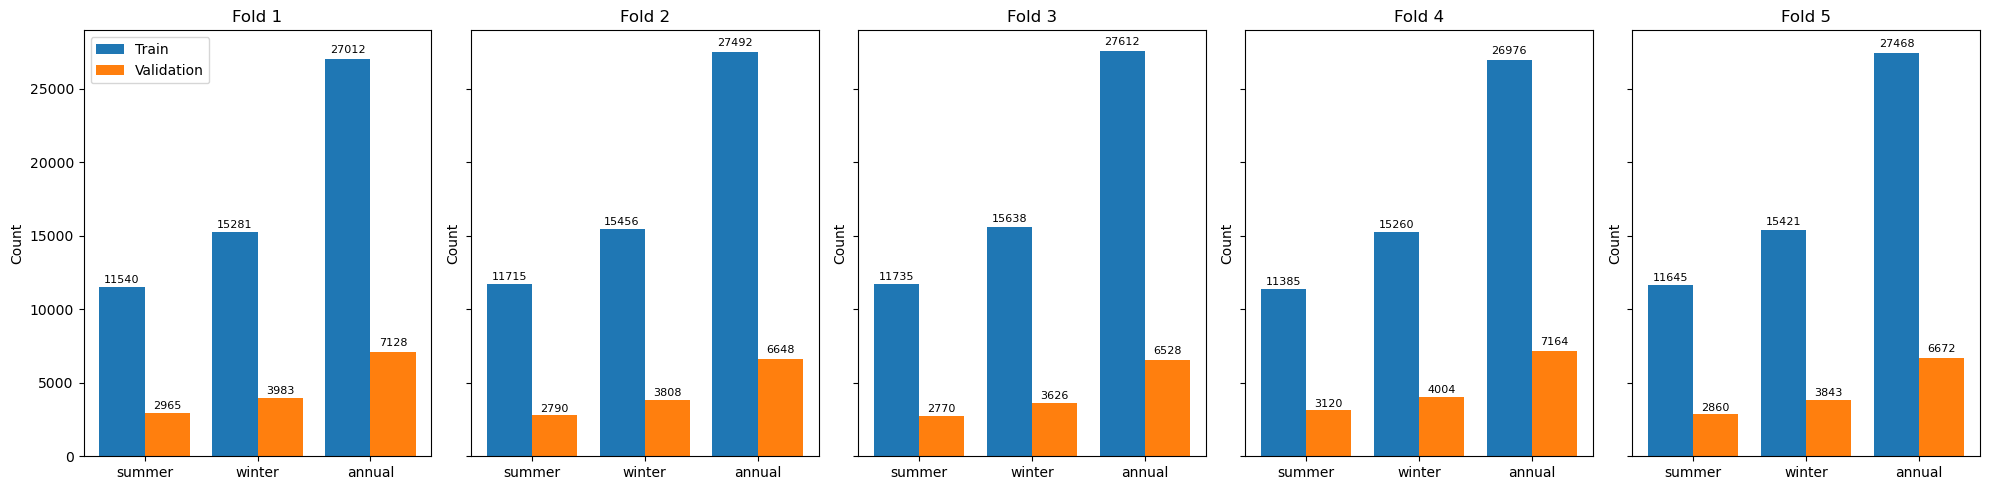

In [22]:
plot_train_val_counts(df_train_X, splits_s)

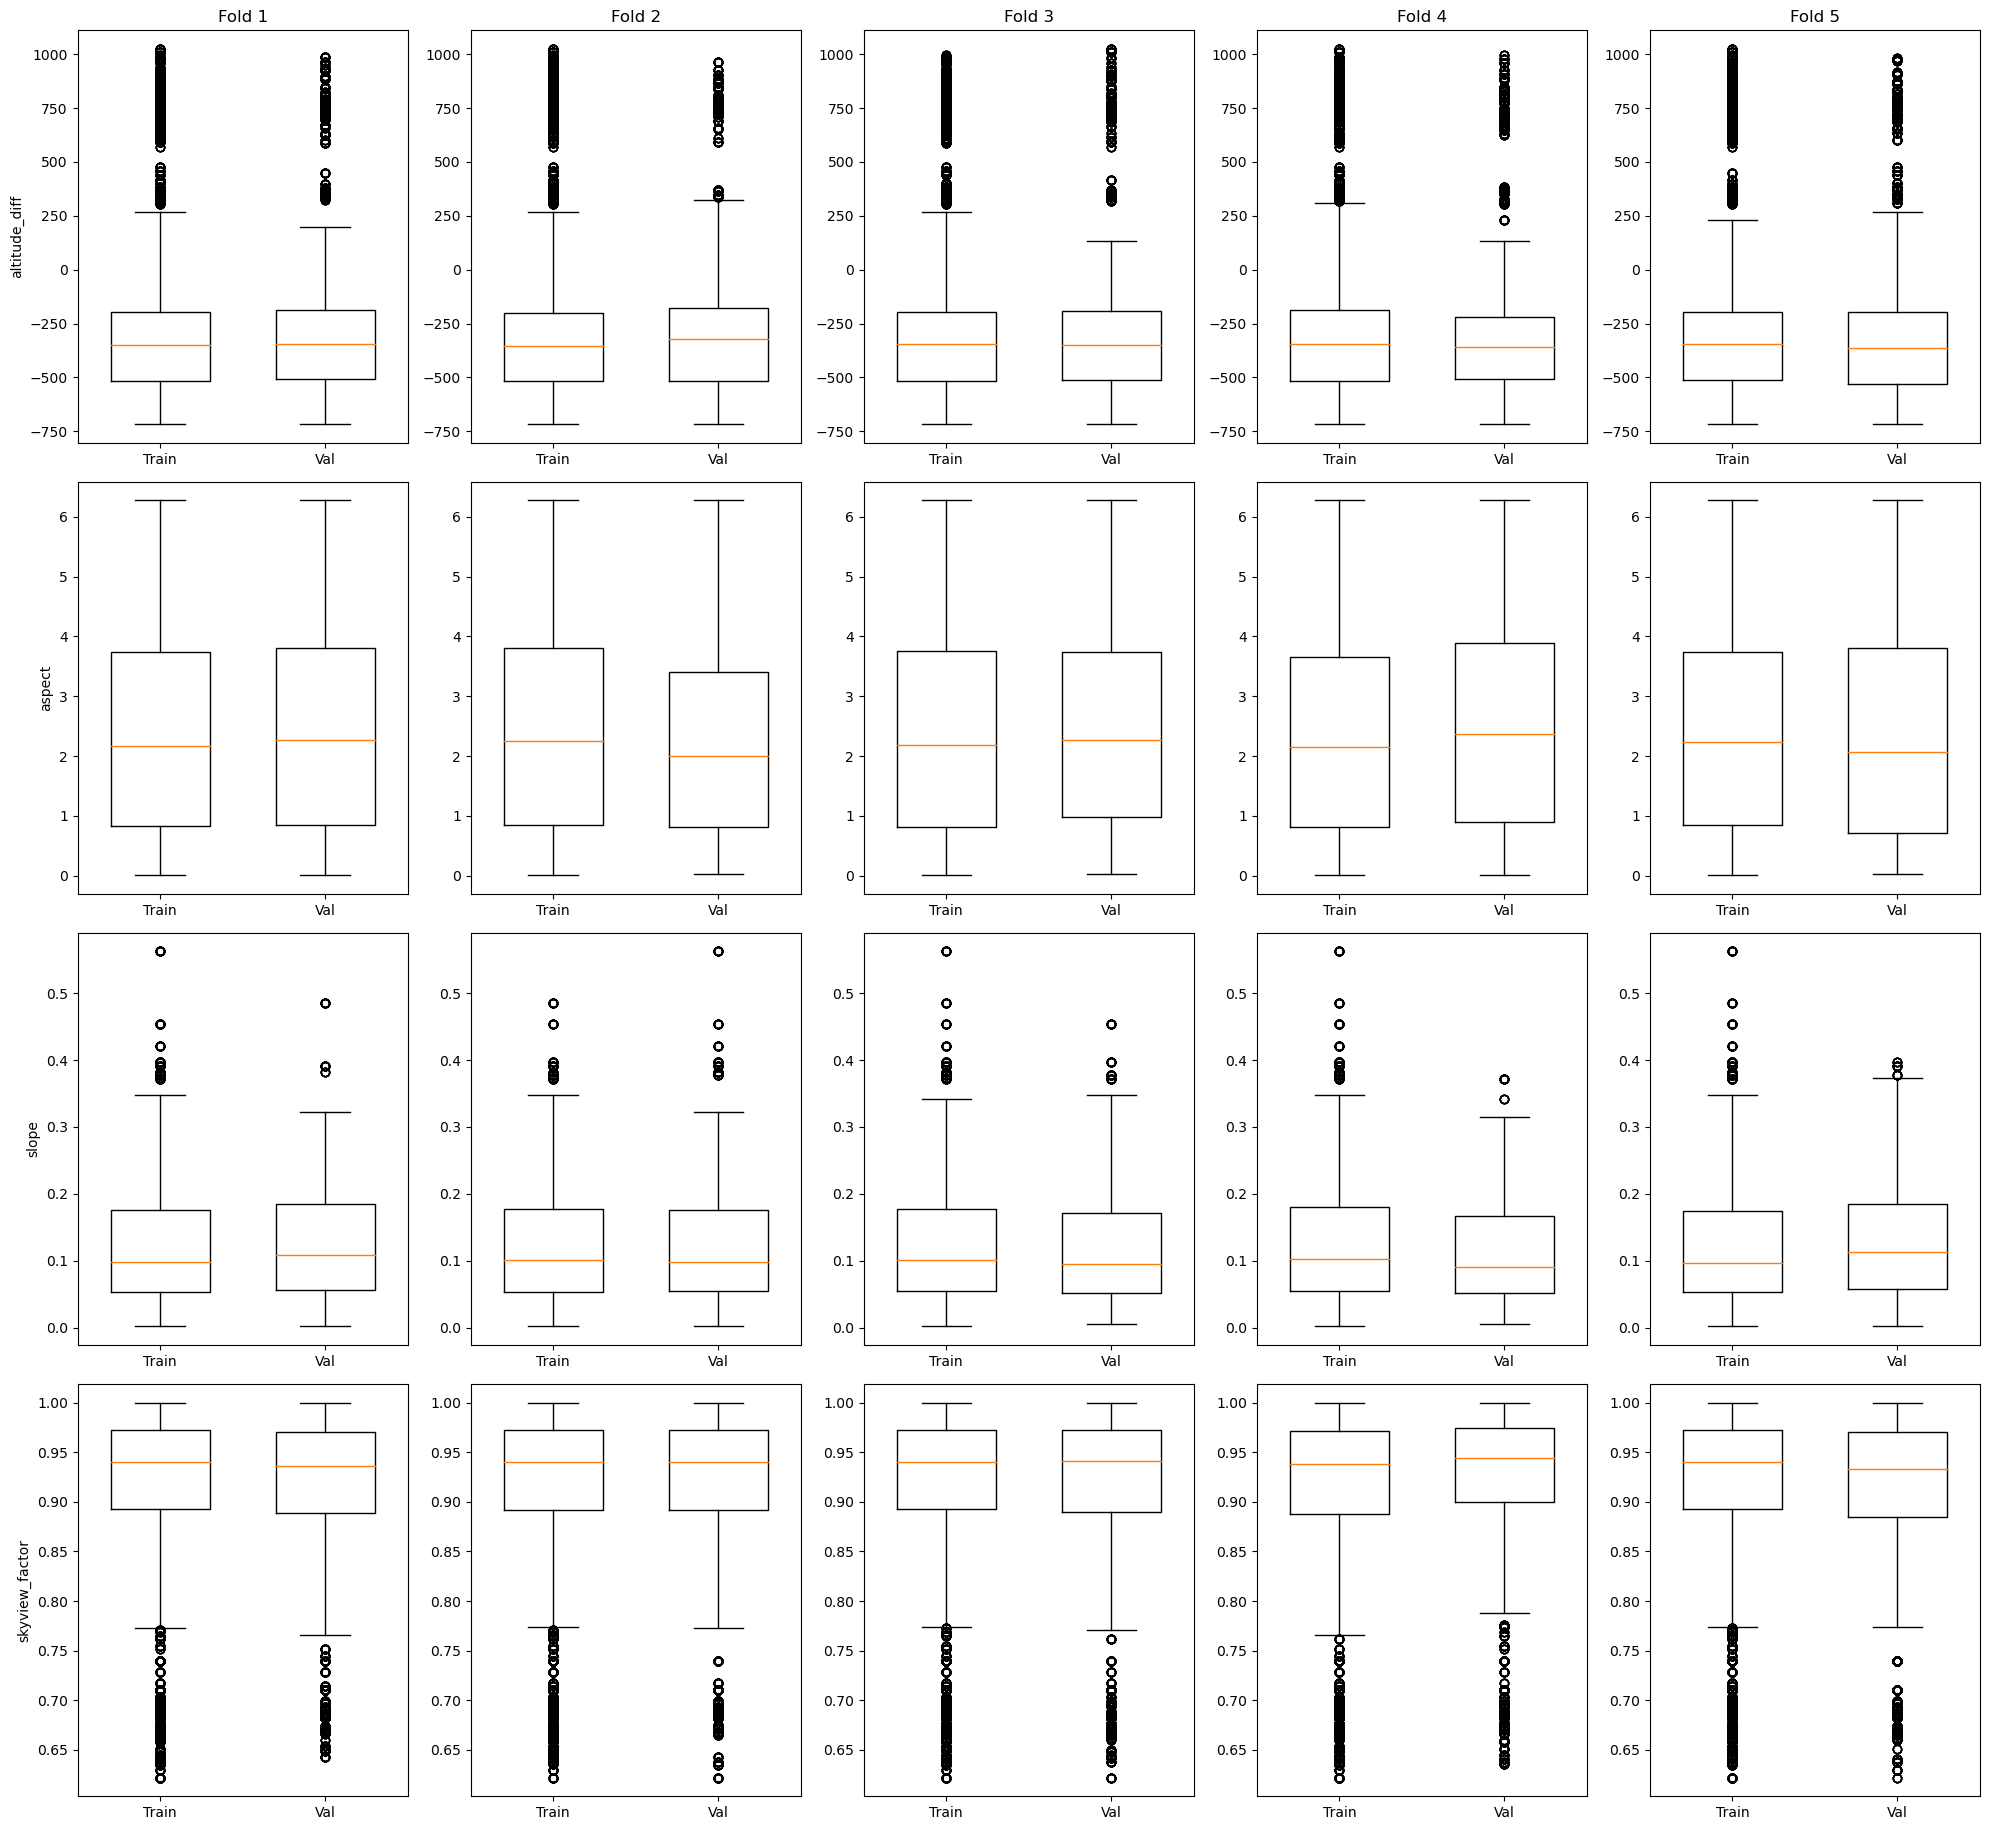

In [23]:
# Plot distribution of topographical features
feature_names_topo = ['altitude_diff', 'aspect', 'slope', 'skyview_factor']

plot_feature_distributions(df_train_X, feature_names_topo, type='train', folds=5, splits_s=splits_s)

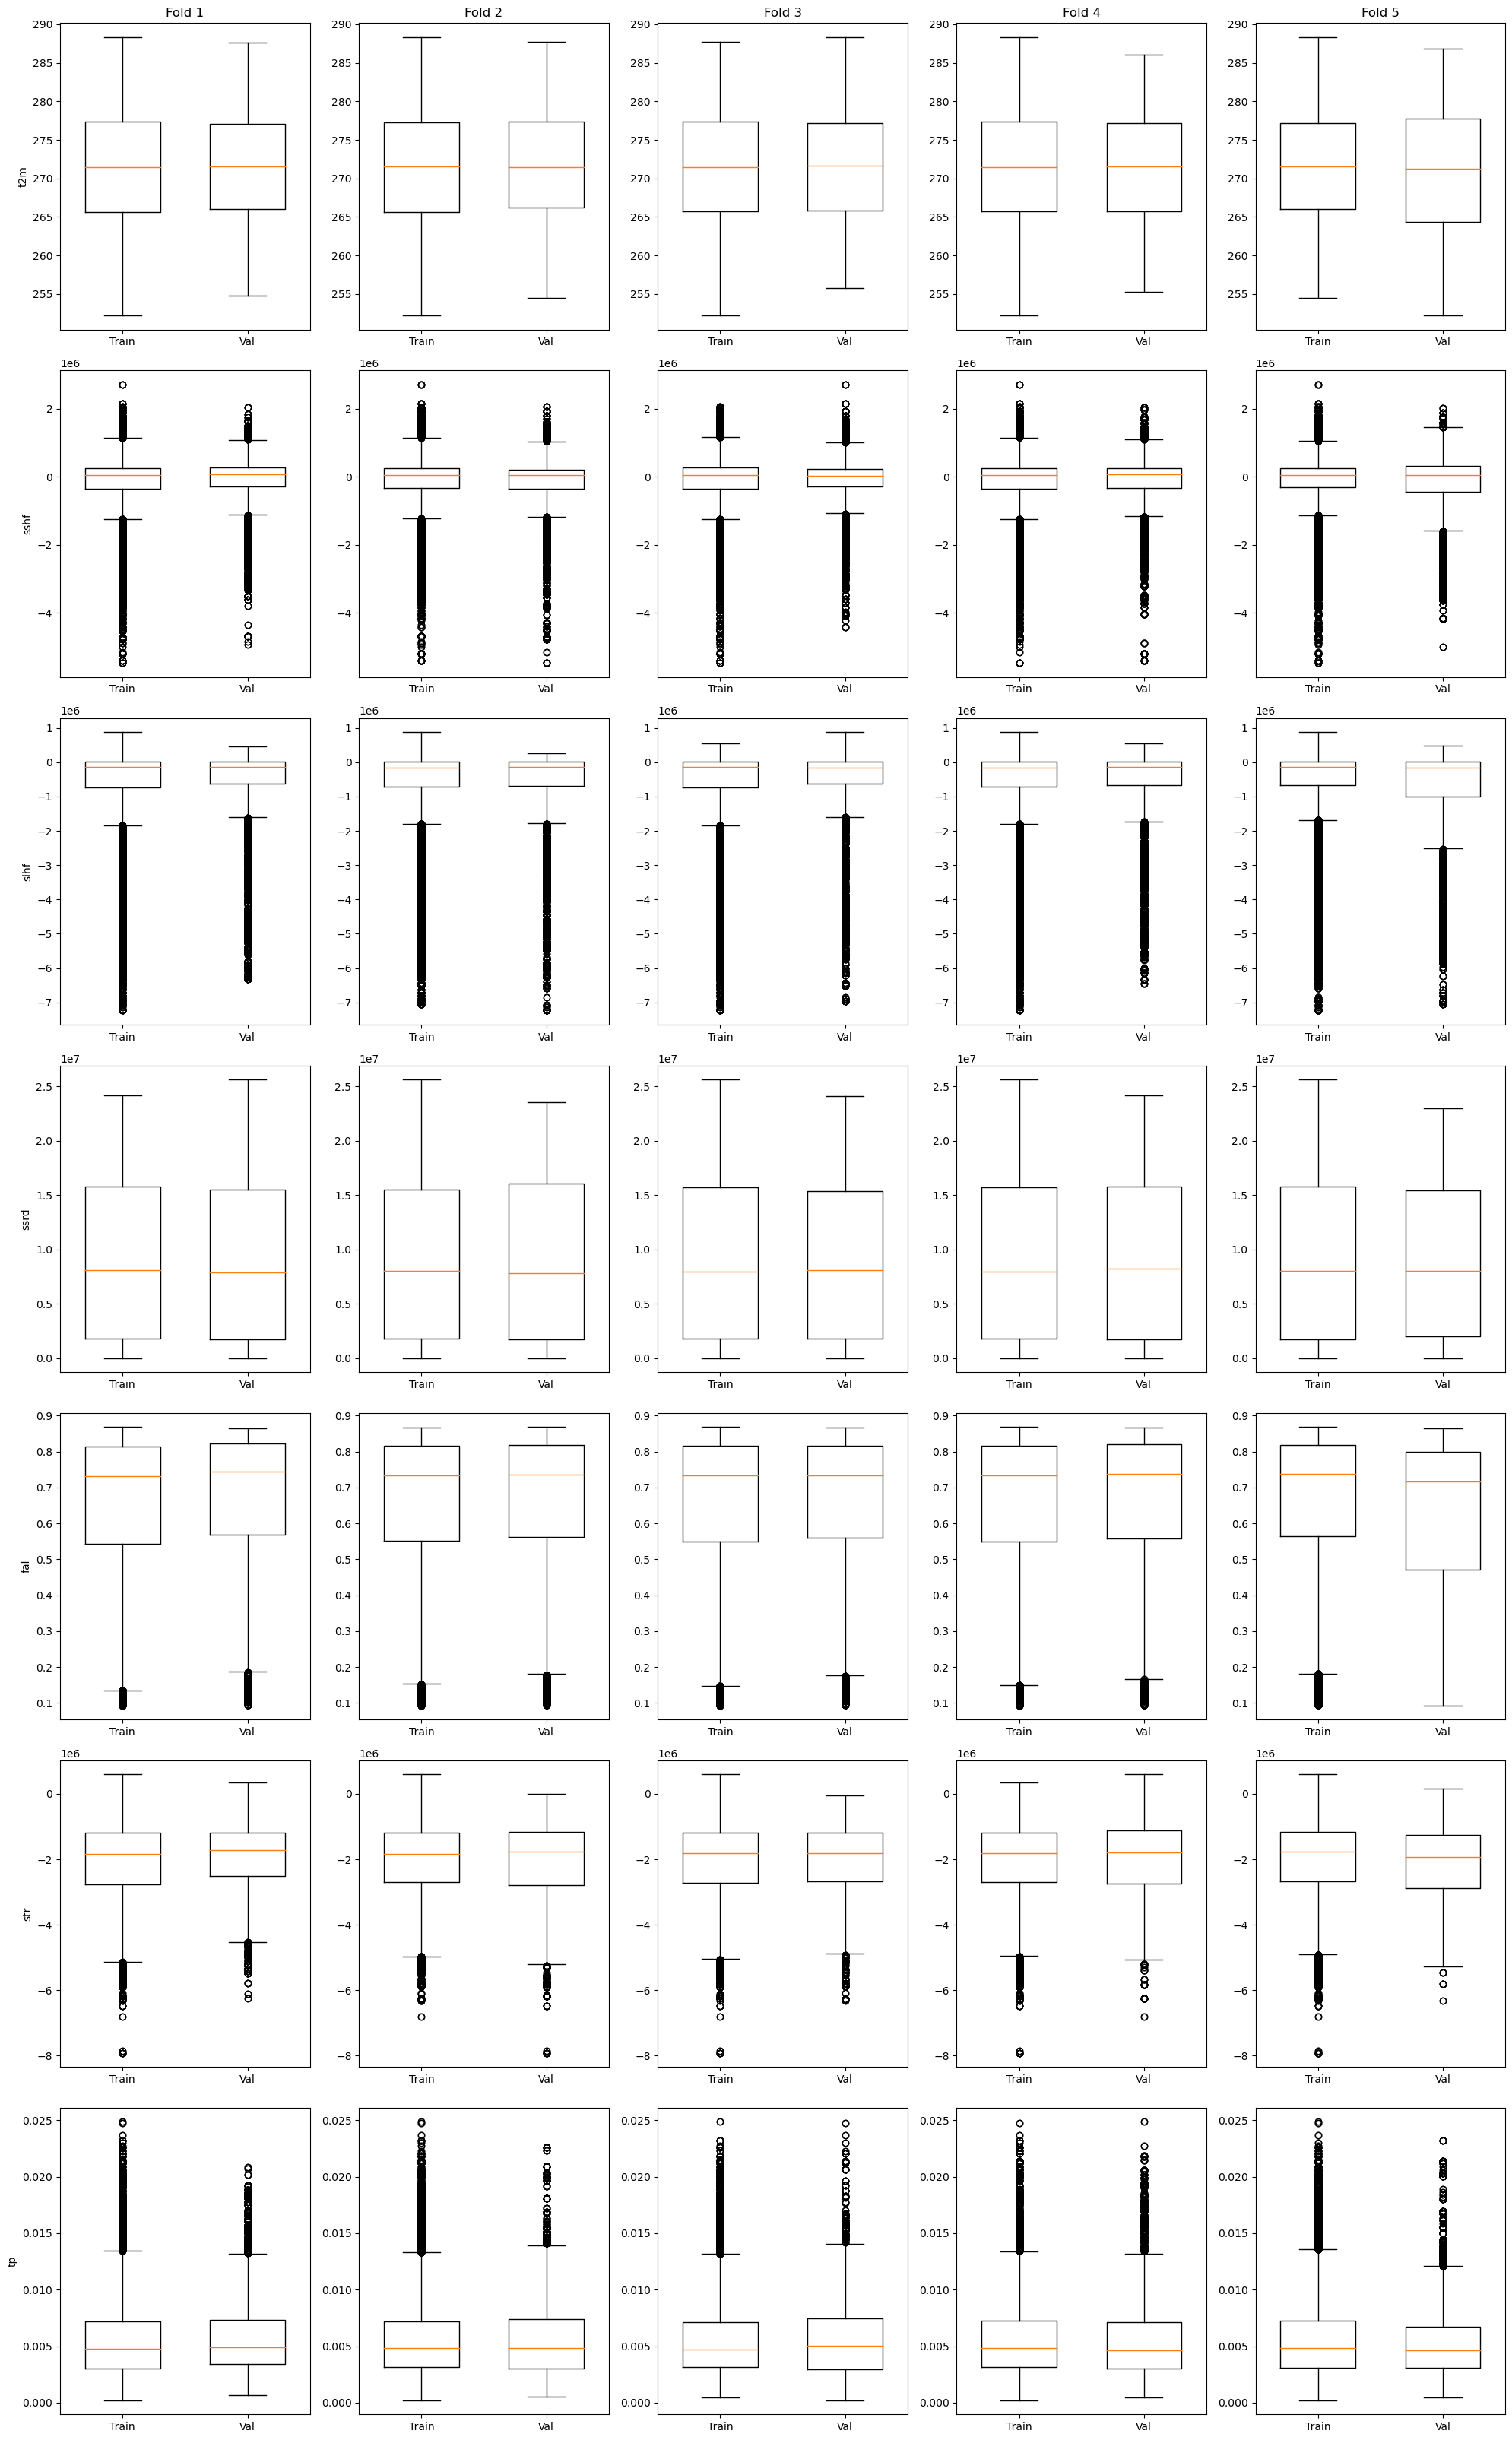

In [29]:
# Plot distribution of climate features
feature_names_climate = ['t2m', 'sshf', 'slhf', 'ssrd', 'fal', 'str', 'tp']

plot_feature_distributions(df_train_X, feature_names_climate, type='train', folds=5, splits_s=splits_s)

## 3 Finalize test dataset

In [24]:
# Select features for test
df_test_X_reduce = df_test_final.drop(['balance','year','BREID'], axis=1)

# Move id and n_months to the end of the dataframe (these are to be used as metadata)
df_test_X = df_test_X_reduce[[c for c in df_test_X_reduce if c not in ['id','n_months','month']] + ['id','n_months','month']]

# Select labels for test
df_test_y = df_test_final[['balance']]

# Get arrays of features+metadata and targets
#X_test_unnorm, y_test = df_test_X.values, df_test_y.values
X_test, y_test = df_test_X.values, df_test_y.values

In [25]:
df_test_X

,altitude_diff,aspect,slope,skyview_factor,t2m,sshf,slhf,ssrd,fal,str,tp,id,n_months,month
0,-129.772081,0.629597,0.278773,0.778997,277.677979,4.286715e+05,-237874.5,20979516.0,0.580414,-3367191.50,0.001159,0,5,may
1,-129.772081,0.629597,0.278773,0.778997,283.339630,-2.133166e+06,-4024573.5,17728592.0,0.198752,-3994740.00,0.003054,0,5,jun
2,-129.772081,0.629597,0.278773,0.778997,283.829285,-2.731458e+06,-5184939.5,15538729.0,0.131911,-4661453.00,0.003977,0,5,jul
3,-129.772081,0.629597,0.278773,0.778997,283.778412,-1.295387e+06,-3545874.5,10510849.0,0.130799,-4018348.50,0.004691,0,5,aug
4,-129.772081,0.629597,0.278773,0.778997,280.982513,9.352438e+03,-1756179.5,6908671.0,0.130148,-4441106.50,0.001449,0,5,sep
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24908,-160.580241,2.906044,0.131717,0.932281,277.690887,-5.189375e+02,-71670.0,17926120.0,0.530146,-2093793.25,0.003567,3091,12,may
24909,-160.580241,2.906044,0.131717,0.932281,280.319031,1.046328e+05,-101796.5,13385372.0,0.480811,162197.00,0.008162,3091,12,jun
24910,-160.580241,2.906044,0.131717,0.932281,282.416504,-2.174798e+06,-4535185.5,15446657.0,0.183955,-3726261.25,0.007537,3091,12,jul
24911,-160.580241,2.906044,0.131717,0.932281,281.939026,-1.997971e+06,-3884410.5,11212546.0,0.135438,-3417520.00,0.007390,3091,12,aug


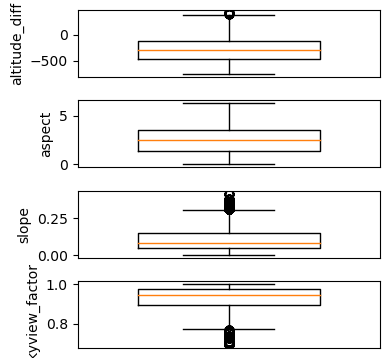

In [26]:
# Visualize test distributions
plot_feature_distributions(df_test_X, feature_names_topo, type='test', folds=1, splits_s=None)

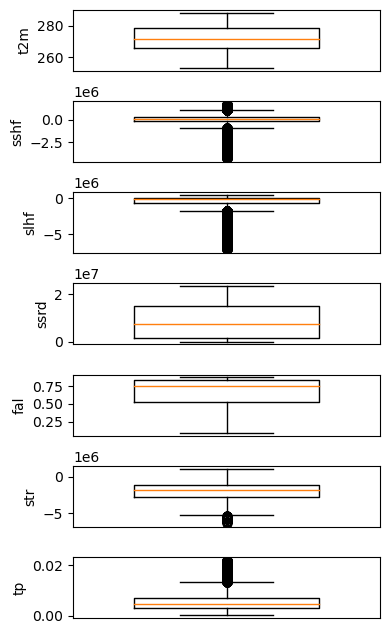

In [30]:
# Visualize test distributions
plot_feature_distributions(df_test_X, feature_names_climate, type='test', folds=1, splits_s=None)

## 4 Model training and validation

### 4.0 Test model setup: custom_mse_scorer with GridSearchCV on smaller version of dataset

In [163]:
# Set up dataset with random sample from annual, winter, summer

# Get random sample of annual, summer, winter
df_train_annual_sample = df_train_annual_clean.sample(n=1000, random_state=42)
df_train_summer_sample = df_train_summer_clean.sample(n=1000, random_state=42)
df_train_winter_sample = df_train_winter_clean.sample(n=1000, random_state=42)

# Reshape dataframes to monthly resolution
df_train_summer_sample_final = reshape_dataset_monthly(df_train_summer_sample, id_vars, variables, summer_months_order)
df_train_winter_sample_final = reshape_dataset_monthly(df_train_winter_sample, id_vars, variables, winter_months_order)
df_train_annual_sample_final = reshape_dataset_monthly(df_train_annual_sample, id_vars, variables, annual_months_order)

# Combine training data in one dataframe
df_train_summer_sample_final.reset_index(drop=True, inplace=True)
df_train_winter_sample_final.reset_index(drop=True, inplace=True)
df_train_annual_sample_final.reset_index(drop=True, inplace=True)

data_list = [df_train_summer_sample_final, df_train_winter_sample_final, df_train_annual_sample_final]
df_train_sample_final = pd.concat(data_list)
df_train_sample_final


,id,BREID,year,altitude_diff,balance,aspect,slope,n_months,month,t2m,sshf,slhf,ssrd,fal,str,tp
0,0,596,1963,11.181943,-3.41,2.509464,0.238202,5,may,274.658875,1.493194e+04,-375995.0,18766128.0,0.596335,-2832247.00,0.001702
1,0,596,1963,11.181943,-3.41,2.509464,0.238202,5,jun,274.336243,-1.636112e+05,-521774.5,21166500.0,0.613368,-2748427.50,0.001953
2,0,596,1963,11.181943,-3.41,2.509464,0.238202,5,jul,277.882172,-1.717710e+06,-2857569.5,15175713.0,0.282537,-3019285.50,0.004025
3,0,596,1963,11.181943,-3.41,2.509464,0.238202,5,aug,281.432678,-1.826724e+06,-3644167.5,11799862.0,0.123184,-4122848.50,0.002591
4,0,596,1963,11.181943,-3.41,2.509464,0.238202,5,sep,276.588593,-4.764911e+05,-1239184.5,6023235.0,0.295263,-2144487.50,0.006047
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11995,8497,3129,1967,-592.166788,1.58,2.526225,0.068208,12,may,274.327118,-9.279995e+05,-247320.5,17505508.0,0.618479,-2179443.00,0.004908
11996,8497,3129,1967,-592.166788,1.58,2.526225,0.068208,12,jun,277.050171,-8.421614e+05,101172.0,20268490.0,0.551025,-2504472.50,0.007480
11997,8497,3129,1967,-592.166788,1.58,2.526225,0.068208,12,jul,278.294403,-4.923712e+05,282694.5,15490057.0,0.481296,-862670.75,0.006605
11998,8497,3129,1967,-592.166788,1.58,2.526225,0.068208,12,aug,280.939240,-1.117702e+06,-2140415.0,12475600.0,0.284415,-2001555.00,0.006391


In [112]:
# USING GROUP K-FOLD TO SPLIT ON ID

# Select features for training
df_train_X_reduce = df_train_sample_final.drop(['balance','year','BREID'], axis=1)

# Move id and n_months to the end of the dataframe (these are to be used as metadata)
df_train_X_sample = df_train_X_reduce[[c for c in df_train_X_reduce if c not in ['id','n_months','month']] + ['id','n_months','month']]

# Select labels for training
df_train_y_sample = df_train_sample_final[['balance']]

# Get arrays of features+metadata and targets
X_train_s, y_train_s = df_train_X_sample.values, df_train_y_sample.values

# Get glacier IDs from training dataset (in the order of which they appear in training dataset).
# gp_s is an array with shape equal to the shape of X_train_s and y_train_s.
gp_s_s = np.array(df_train_sample_final['id'].values)

# Use five folds
group_kf_s = GroupKFold(n_splits=5)

# Split into folds according to group by glacier ID.
# For each unique glacier ID, indices in gp_s indicate which rows in X_train_s and y_train_s belong to the glacier.
splits_s_s = list(group_kf_s.split(X_train_s, y_train_s, gp_s_s))

print(len(gp_s_s))
print(y_train_s.shape)
print(X_train_s.shape)
print(df_train_X_sample.columns)
print(df_train_y_sample.columns)

# Check fold indices for training/validation data
fold_indices = []

for train_index, val_index in group_kf_s.split(X_train_s, y_train_s, gp_s_s):
    #print("TRAIN:", train_index, "VALIDATION:", val_index)
    print("shape(train):", train_index.shape, "test:", val_index.shape)
    fold_indices.append((train_index, val_index))


4800
(4800, 1)
(4800, 13)
Index(['altitude_diff', 'aspect', 'slope', 't2m', 'sshf', 'slhf', 'ssrd',
       'fal', 'str', 'tp', 'id', 'n_months', 'month'],
      dtype='object')
Index(['balance'], dtype='object')


In [166]:
# USING GROUP K-FOLD TO SPLIT ON ID

# Select features for training
df_train_X_reduce = df_train_sample_final.drop(['balance','year','BREID'], axis=1)

# Move id and n_months to the end of the dataframe (these are to be used as metadata)
df_train_X_sample = df_train_X_reduce[[c for c in df_train_X_reduce if c not in ['id','n_months','month']] + ['id','n_months','month']]

# Select labels for training
df_train_y_sample = df_train_sample_final[['balance']]

# Get arrays of features+metadata and targets
X_train_s, y_train_s = df_train_X_sample.values, df_train_y_sample.values

# Define the year intervals for the folds
year_intervals = [
    (1960, 1969),  # Fold 1
    (1970, 1979),  # Fold 2
    (1980, 1994),  # Fold 3
    (1995, 2009),  # Fold 4
    (2010, 2021)   # Fold 5
]

# Add a 'fold' column based on the 'year' intervals
def assign_fold(row):
    for i, (start_year, end_year) in enumerate(year_intervals):
        if start_year <= row['year'] <= end_year:
            return i
    return -1  # Return -1 if year is not in any interval (should not happen)

df_train_sample_final['fold'] = df_train_sample_final.apply(assign_fold, axis=1)

# Verify that all rows have been assigned a valid fold
if (df_train_sample_final['fold'] == -1).any():
    raise ValueError("Some rows have not been assigned a valid fold")

# Group by 'id' to maintain groups of rows with the same 'id'
grouped = df_train_sample_final.groupby('id')

# Create indices for each fold
folds = [([], []) for _ in range(5)]  # Initialize with 5 empty train/test index lists

# Distribute groups into folds
for _, group in grouped:
    fold = group['fold'].iloc[0]  # All rows in group have the same fold
    for fold_idx in range(5):
        if fold == fold_idx:
            folds[fold_idx][1].extend(group.index)  # Assign group to test set of this fold
        else:
            folds[fold_idx][0].extend(group.index)  # Assign group to train set of other folds

# Convert lists to numpy arrays
folds = [(np.array(train_indices), np.array(test_indices)) for train_indices, test_indices in folds]

# Define the custom cross-validator
class CustomFoldIterator(BaseCrossValidator):
    def __init__(self, fold_indices):
        self.fold_indices = fold_indices

    def split(self, X, y=None, groups=None):
        for train_indices, test_indices in self.fold_indices:
            yield train_indices, test_indices

    def get_n_splits(self, X=None, y=None, groups=None):
        return len(self.fold_indices)

# Setup and Execute GridSearchCV
custom_cv_s = CustomFoldIterator(folds)

# Create splits
splits_s_s = list(custom_cv_s.split(X_train_s, y_train_s))

# Convert Int64Index to numpy arrays 
splits_s_s = [(np.array(train_indices), np.array(test_indices)) for (train_indices, test_indices) in splits_s_s]

# Print number of instances in each split
for i, (train_indices, test_indices) in enumerate(splits_s_s):
    print(f"Fold {i+1} - Train: {len(train_indices)}, Test: {len(test_indices)}")

# Check fold indices for training/validation data
fold_indices = []

for i, (train_index, val_index) in enumerate(splits_s_s):
    print(f"Fold {i+1}")
    print("TRAIN:", train_index)
    print("VALIDATION:", val_index)
    print("shape(train):", train_index.shape, "shape(validation):", val_index.shape)
    fold_indices.append((train_index, val_index))

Fold 1 - Train: 16183, Test: 7817
Fold 2 - Train: 18369, Test: 5631
Fold 3 - Train: 21464, Test: 2536
Fold 4 - Train: 19019, Test: 4981
Fold 5 - Train: 20965, Test: 3035
Fold 1
TRAIN: [  195   196   197 ... 11877 11878 11879]
VALIDATION: [    0     1     2 ... 11997 11998 11999]
shape(train): (16183,) shape(validation): (7817,)
Fold 2
TRAIN: [    0     1     2 ... 11997 11998 11999]
VALIDATION: [  645   646   647 ... 11589 11590 11591]
shape(train): (18369,) shape(validation): (5631,)
Fold 3
TRAIN: [    0     1     2 ... 11997 11998 11999]
VALIDATION: [  195   196   197 ... 10401 10402 10403]
shape(train): (21464,) shape(validation): (2536,)
Fold 4
TRAIN: [    0     1     2 ... 11997 11998 11999]
VALIDATION: [  320   321   322 ... 11865 11866 11867]
shape(train): (19019,) shape(validation): (4981,)
Fold 5
TRAIN: [    0     1     2 ... 11997 11998 11999]
VALIDATION: [  640   641   642 ... 11877 11878 11879]
shape(train): (20965,) shape(validation): (3035,)


In [173]:
df_train_X_sample

,altitude_diff,aspect,slope,t2m,sshf,slhf,ssrd,fal,str,tp,fold,id,n_months,month
0,11.181943,2.509464,0.238202,274.658875,1.493194e+04,-375995.0,18766128.0,0.596335,-2832247.00,0.001702,0,0,5,may
1,11.181943,2.509464,0.238202,274.336243,-1.636112e+05,-521774.5,21166500.0,0.613368,-2748427.50,0.001953,0,0,5,jun
2,11.181943,2.509464,0.238202,277.882172,-1.717710e+06,-2857569.5,15175713.0,0.282537,-3019285.50,0.004025,0,0,5,jul
3,11.181943,2.509464,0.238202,281.432678,-1.826724e+06,-3644167.5,11799862.0,0.123184,-4122848.50,0.002591,0,0,5,aug
4,11.181943,2.509464,0.238202,276.588593,-4.764911e+05,-1239184.5,6023235.0,0.295263,-2144487.50,0.006047,0,0,5,sep
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11995,-592.166788,2.526225,0.068208,274.327118,-9.279995e+05,-247320.5,17505508.0,0.618479,-2179443.00,0.004908,0,8497,12,may
11996,-592.166788,2.526225,0.068208,277.050171,-8.421614e+05,101172.0,20268490.0,0.551025,-2504472.50,0.007480,0,8497,12,jun
11997,-592.166788,2.526225,0.068208,278.294403,-4.923712e+05,282694.5,15490057.0,0.481296,-862670.75,0.006605,0,8497,12,jul
11998,-592.166788,2.526225,0.068208,280.939240,-1.117702e+06,-2140415.0,12475600.0,0.284415,-2001555.00,0.006391,0,8497,12,aug


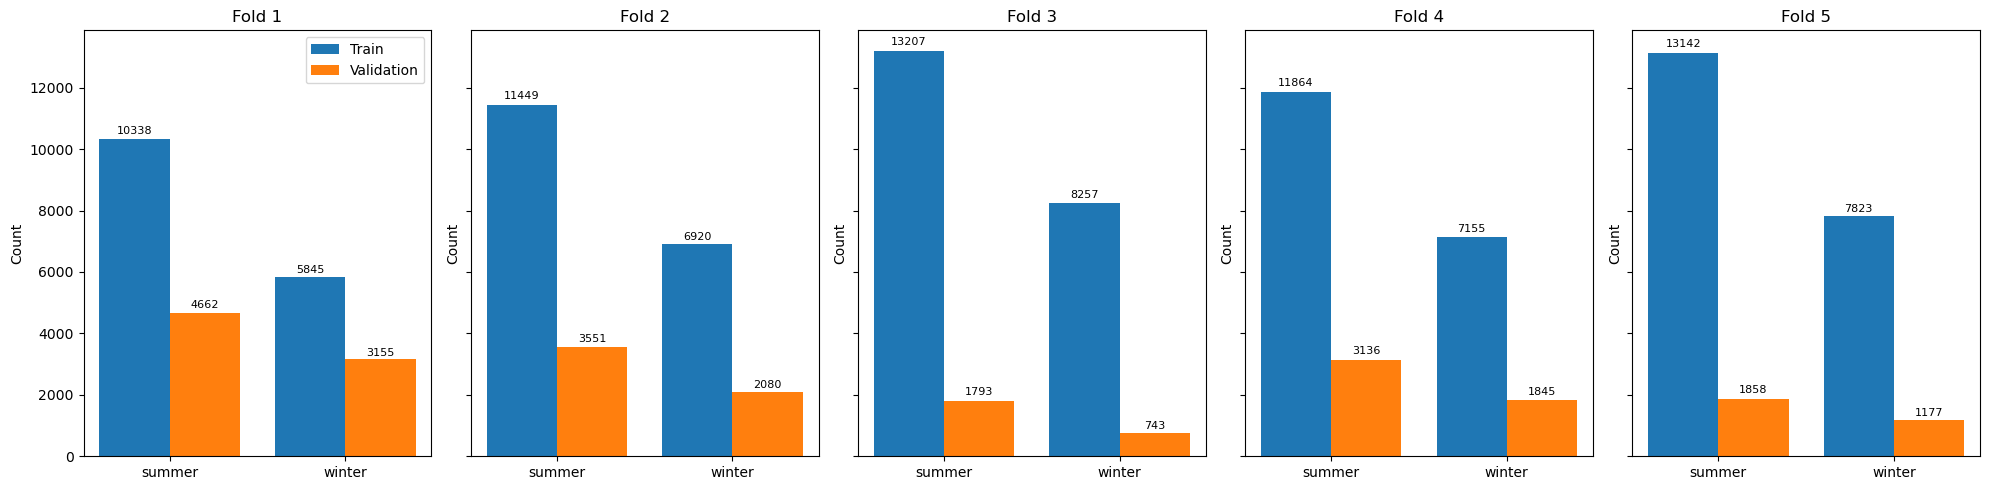

In [167]:
# Count number of annual and seasonal per fold

fig, axes = plt.subplots(1, 5, figsize=(20, 5), sharey=True)

# Create a color map or list for the bars
colors = ['C0', 'C1']

n_months_to_season = {5: 'summer', 7: 'winter', 12: 'annual'}

for i, (train_index, val_index) in enumerate(splits_s_s):
    ax = axes[i]

    n_months_train = df_train_X_sample.iloc[train_index]['n_months']
    n_months_val = df_train_X_sample.iloc[val_index]['n_months']
    
    # Counts
    n_months_train_counts = dict(zip(*np.unique(n_months_train, return_counts=True)))
    n_months_val_counts = dict(zip(*np.unique(n_months_val, return_counts=True)))
    
    #n_months_values = sorted(set(n_months_train_counts.keys()).union(n_months_val_counts.keys()))
    n_months_values = sorted(set(n_months_train_counts.keys()).union(n_months_val_counts.keys()))
    #print(n_months_values)
    season_names = [n_months_to_season[n_months] for n_months in n_months_values]

    train_positions = np.arange(len(n_months_values))
    val_positions = train_positions + 0.4 
    
    train_counts = [n_months_train_counts.get(x, 0) for x in n_months_values]
    ax.bar(train_positions, train_counts, width=0.4, label='Train', color=colors[0])
    
    val_counts = [n_months_val_counts.get(x, 0) for x in n_months_values]
    ax.bar(val_positions, val_counts, width=0.4, label='Validation', color=colors[1])

    # Annotate each bar with the respective count
    for j in range(len(n_months_values)):
        train_count = n_months_train_counts.get(n_months_values[j], 0)
        val_count = n_months_val_counts.get(n_months_values[j], 0)
        train_pos = train_positions[j]
        val_pos = val_positions[j]
        
        ax.text(train_pos, train_count + max(train_count, val_count) * 0.01, str(train_count),
                ha='center', va='bottom', fontsize=8, color='k')

        ax.text(val_pos, val_count + max(train_count, val_count) * 0.01, str(val_count),
                ha='center', va='bottom', fontsize=8, color='k')
    
    ax.set_title(f'Fold {i+1}')
    #ax.set_xlabel('n_months')
    ax.set_ylabel('Count')
    ax.set_xticks(train_positions + 0.2) 
    #ax.set_xticklabels(n_months_values)  
    ax.set_xticklabels(season_names)
    
    if i == 0:
        ax.legend()

plt.tight_layout()
plt.show()

In [115]:
# Define hyperparameter grid
param_grid = {
    'max_depth': [3, 4, 5],#, 5, 6, 7, 8],
    'learning_rate': [0.01, 0.1],#, 0.2, 0.3],
    'n_estimators': [100, 200, 300, 400],
    'gamma':[0]#, 1, 10],
    }

xgb_model_s = CustomXGBRegressor()

clf = GridSearchCV(xgb_model_s, 
                   param_grid, 
                   cv=splits_s_s,
                   verbose=2, 
                   n_jobs=4, 
                   #scoring=custom_mse_scorer, 
                   scoring = None, # Uses default in CustomXGBRegressor()
                   refit=True, 
                   error_score='raise',
                   return_train_score=True) # Default False. If False, cv_results_ will not include training scores.

#X_features = X_train[:,:-3]

clf.fit(X_train_s, y_train_s)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


C:\Program Files\Anaconda3\envs\ML_MB_Norway_env\lib\site-packages\xgboost\core.py:160: UserWarning: [11:32:22] WARNING: D:\bld\xgboost-split_1705650032250\work\src\learner.cc:742: 
Parameters: { "metadata_shape" } are not used.

  warnings.warn(smsg, UserWarning)


GridSearchCV(cv=[(array([   0,    1,    2, ..., 4785, 4786, 4787]),
                  array([  10,   11,   12,   13,   14,   35,   36,   37,   38,   39,   55,
         56,   57,   58,   59,   60,   61,   62,   63,   64,   85,   86,
         87,   88,   89,  120,  121,  122,  123,  124,  145,  146,  147,
        148,  149,  170,  171,  172,  173,  174,  195,  196,  197,  198,
        199,  220,  221,  222,  223,  224,  260,  261,  262,  263,  264,
        285,  286,  287,  288,  289,  335,  336,  337,  338,  339,  340,
        341,  342,  343,  344,  365,  366,  367,  368,  369,  375,  376,
        377,  378,...
                                          max_delta_step=None, max_depth=None,
                                          max_leaves=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          multi_strategy=None,
                                          n_estimators=None, n_jobs=None,
                                          num_parallel_tree=None,
                                          objective='reg:squarederror', ...),
             n_jobs=4,
             param_grid={'gamma': [0], 'learning_rate': [0.01, 0.1],
                         'max_depth': [3, 4, 5],
                         'n_estimators': [100, 200, 300, 400]},
             return_train_score=True, verbose=2)

In [116]:
clf.cv_results_

{'mean_fit_time': array([ 2.61558394,  5.51799755,  8.54584718, 12.05234299,  2.99711914,
         5.83598604,  9.22830358, 13.75065036,  3.87030668,  7.37608309,
        11.18019438, 15.31760588,  3.65978427,  7.18985877, 10.59135833,
        13.94584832,  3.51128964,  7.03577757, 10.94791026, 15.75783353,
         3.64811478,  6.95111113, 12.09521241, 14.19531493]),
 'std_fit_time': array([0.04828631, 0.1070452 , 0.17380347, 0.1970568 , 0.10068233,
        0.07755495, 0.32981464, 0.62857951, 0.3427156 , 0.11067639,
        0.09483409, 0.35095483, 0.13218643, 0.09463175, 0.15108734,
        0.10427224, 0.04852474, 0.08707772, 0.55192382, 0.52178398,
        0.16297478, 0.16508729, 0.52088337, 1.91688058]),
 'mean_score_time': array([0.00837464, 0.00812197, 0.01034493, 0.01098919, 0.00856733,
        0.00974278, 0.01181026, 0.01694136, 0.01224427, 0.013064  ,
        0.01878195, 0.01918049, 0.00850897, 0.01386962, 0.00892634,
        0.01182995, 0.01018085, 0.01101847, 0.01339922, 0.01

In [117]:
clf.best_estimator_

CustomXGBRegressor(base_score=None, booster=None, callbacks=None,
                   colsample_bylevel=None, colsample_bynode=None,
                   colsample_bytree=None, device=None,
                   early_stopping_rounds=None, enable_categorical=False,
                   eval_metric=None, feature_types=None, gamma=0,
                   grow_policy=None, importance_type=None,
                   interaction_constraints=None, learning_rate=0.01,
                   max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
                   max_delta_step=None, max_depth=5, max_leaves=None,
                   min_child_weight=None, missing=nan,
                   monotone_constraints=None, multi_strategy=None,
                   n_estimators=400, n_jobs=None, num_parallel_tree=None,
                   objective=<function CustomXGBRegressor.fit.<locals>.custom_objective at 0x000002178B824EE0>, ...)

In [118]:
# Save the model to a binary file
best_model = clf.best_estimator_

best_model.save_model('Models/Custom_loss/xgb_model_mini200_test_phl_200.bin')

C:\Program Files\Anaconda3\envs\ML_MB_Norway_env\lib\site-packages\xgboost\core.py:160: UserWarning: [11:34:14] WARNING: D:\bld\xgboost-split_1705650032250\work\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)


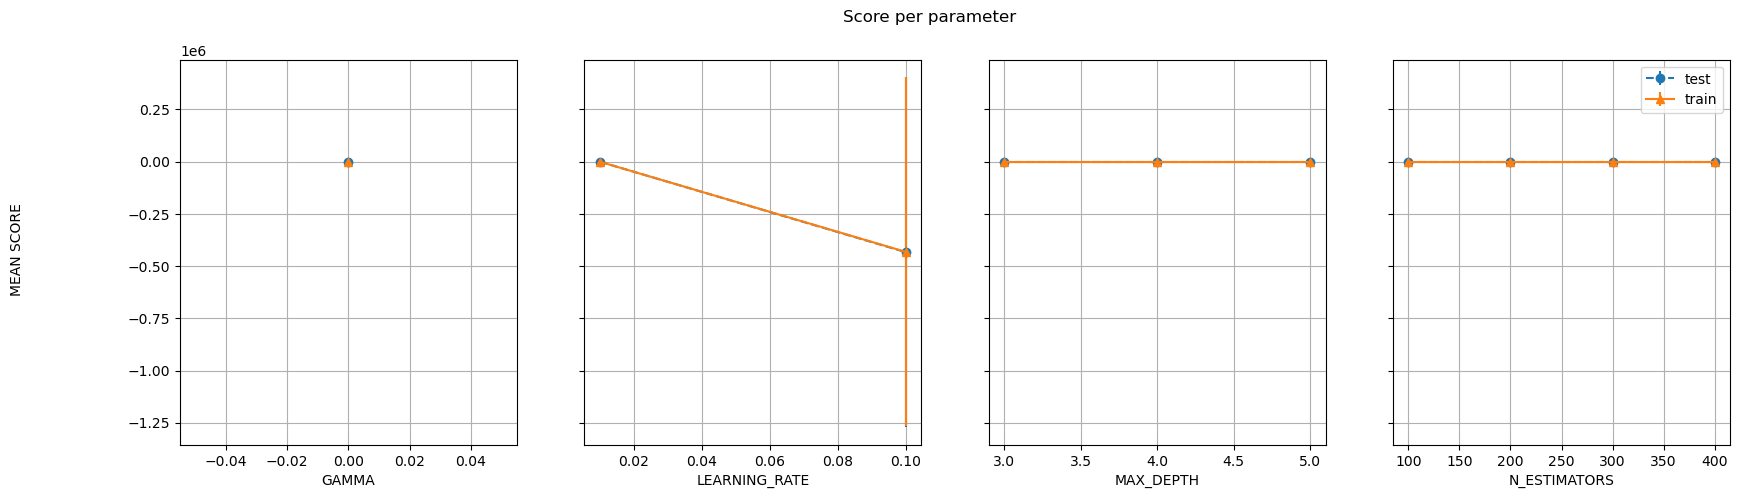

In [100]:
plot_gsearch_results(clf)

C:\Program Files\Anaconda3\envs\ML_MB_Norway_env\lib\site-packages\xgboost\core.py:160: UserWarning: [11:34:19] WARNING: D:\bld\xgboost-split_1705650032250\work\src\learner.cc:742: 
Parameters: { "metadata_shape" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Program Files\Anaconda3\envs\ML_MB_Norway_env\lib\site-packages\xgboost\core.py:160: UserWarning: [11:34:28] WARNING: D:\bld\xgboost-split_1705650032250\work\src\learner.cc:742: 
Parameters: { "metadata_shape" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Program Files\Anaconda3\envs\ML_MB_Norway_env\lib\site-packages\xgboost\core.py:160: UserWarning: [11:34:38] WARNING: D:\bld\xgboost-split_1705650032250\work\src\learner.cc:742: 
Parameters: { "metadata_shape" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Program Files\Anaconda3\envs\ML_MB_Norway_env\lib\site-packages\xgboost\core.py:160: UserWarning: [11:34:47] WARNING: D:\bld\xgboost-split_1705650032250\work\src\learner.cc:742: 
Parameters: { "metadata

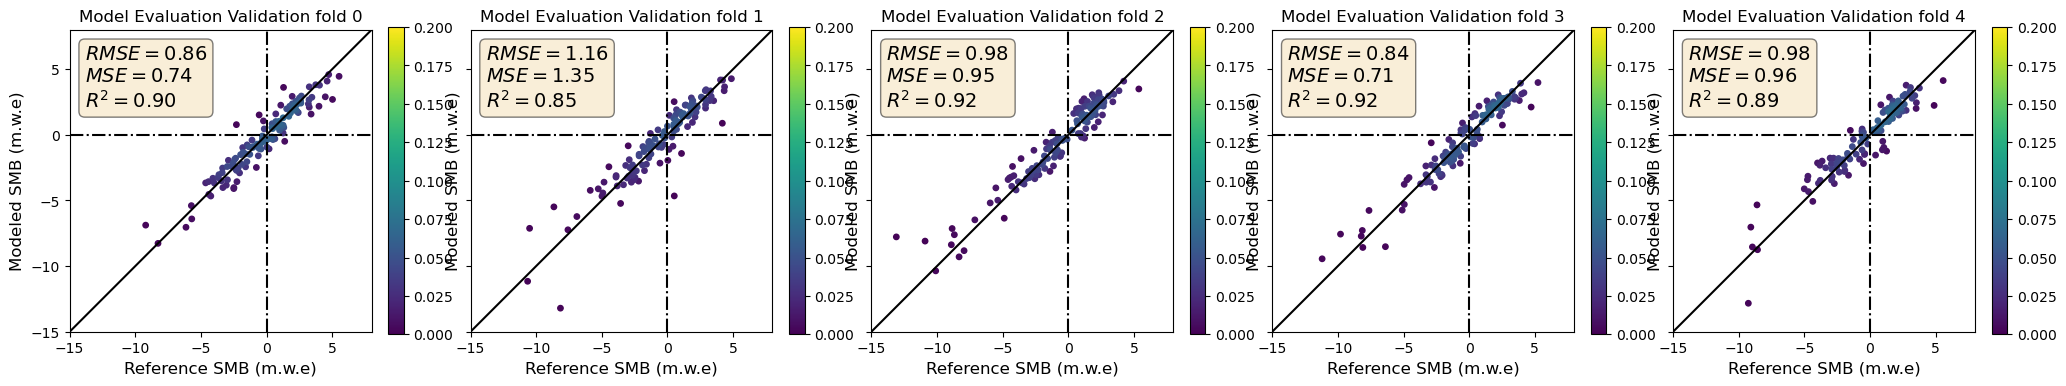

In [119]:
best_model = clf.best_estimator_

# Evaluate validation performance
fig, ax = plt.subplots(1,5, sharex=True, sharey=True, figsize=(25,25))
a = 0    
for train_index, val_index in splits_s_s:
    # Loops over n_splits iterations and gets train and test splits in each fold
    X_train_, X_val_ = X_train_s[train_index], X_train_s[val_index]
    y_train_, y_val_ = y_train_s[train_index], y_train_s[val_index]
    best_model.fit(X_train_, y_train_)
    y_pred = best_model.predict(X_val_)

    title = 'Validation fold ' + str(a)

    y_val_agg, y_pred_agg = get_ytrue_y_pred_agg(y_val_,y_pred,X_val_)

    plot_prediction_subplot(y_val_agg, y_pred_agg, title, ax[a], n_toplot=5000, fold=True)

    a=a+1


In [141]:
print(y_val_agg)
print(y_pred_agg)
print(y_val_agg.shape)
print(y_pred_agg.shape)

[-2.35 -2.08 -3.04 -1.68 -0.59 -2.93 -1.69 -4.   -5.01 -4.69 -1.94 -4.77
 -3.93 -4.36 -2.9  -2.72 -2.39 -1.64 -2.29 -8.61 -9.08 -2.95 -1.92 -2.52
 -1.72  0.94  1.05 -0.41 -1.27 -0.8  -3.82 -1.06 -1.5  -2.55 -2.91 -2.89
 -1.96 -3.38 -3.65 -3.79  1.4   2.24  1.16  2.67  3.53 -0.18  3.2   2.16
  2.75  3.51  4.88  3.76  2.51  3.41  3.1   2.75  5.57  2.19  0.42  1.71
  1.55  1.72  2.35  3.08  3.05  1.46  2.05  1.48  1.86  1.7   1.75  1.87
  1.69  0.99  1.47  2.61  1.98  1.66  1.94  1.7   0.6   0.3  -2.4  -1.35
 -0.6  -0.32 -0.5  -0.5  -1.54 -0.61  1.57 -0.62 -2.95  0.97  0.85  0.54
  1.26 -9.27 -8.57  1.41  2.47 -8.96 -0.6   0.69  0.84  2.12  1.14 -0.71
 -0.53 -0.42  0.56  2.34  0.24  1.4   0.48 -0.62 -4.73  1.56  0.82 -2.78]
[-1.9080148e+00 -1.9088889e+00 -1.5458356e+00 -1.6578267e+00
 -6.4450949e-01 -3.3073556e+00 -1.2694535e+00 -2.3767269e+00
 -4.3284373e+00 -4.4091816e+00 -2.2678347e+00 -3.1172514e+00
 -3.4749699e+00 -4.0131598e+00 -2.7909584e+00 -2.8921592e+00
 -2.2012308e+00 -2.214572

C:\Program Files\Anaconda3\envs\ML_MB_Norway_env\lib\site-packages\xgboost\core.py:160: UserWarning: [11:35:21] WARNING: D:\bld\xgboost-split_1705650032250\work\src\learner.cc:742: 
Parameters: { "metadata_shape" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Program Files\Anaconda3\envs\ML_MB_Norway_env\lib\site-packages\xgboost\core.py:160: UserWarning: [11:35:32] WARNING: D:\bld\xgboost-split_1705650032250\work\src\learner.cc:742: 
Parameters: { "metadata_shape" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Program Files\Anaconda3\envs\ML_MB_Norway_env\lib\site-packages\xgboost\core.py:160: UserWarning: [11:35:42] WARNING: D:\bld\xgboost-split_1705650032250\work\src\learner.cc:742: 
Parameters: { "metadata_shape" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Program Files\Anaconda3\envs\ML_MB_Norway_env\lib\site-packages\xgboost\core.py:160: UserWarning: [11:35:53] WARNING: D:\bld\xgboost-split_1705650032250\work\src\learner.cc:742: 
Parameters: { "metadata

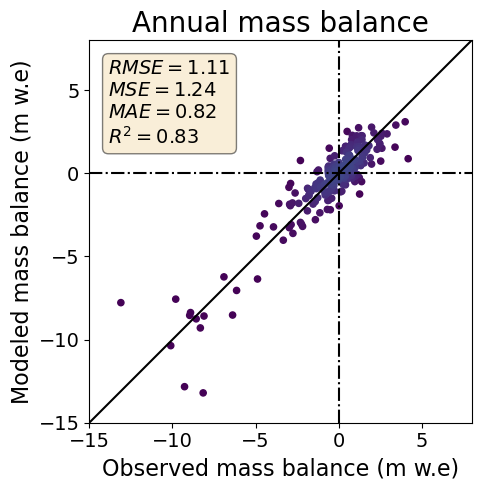

In [120]:
# Plot predictions vs. validation annual mass balance
y_val_annual, y_pred_annual = get_prediction_per_season(X_train_s, y_train_s, splits_s_s, best_model, months=12)
y_val_annual_mean, y_pred_annual_agg = get_ytrue_y_pred_agg_season(y_val_annual, y_pred_annual, X_train_s, months=12)
plot_prediction_per_season(y_val_annual_mean, y_pred_annual_agg, season='Annual')

C:\Program Files\Anaconda3\envs\ML_MB_Norway_env\lib\site-packages\xgboost\core.py:160: UserWarning: [11:36:26] WARNING: D:\bld\xgboost-split_1705650032250\work\src\learner.cc:742: 
Parameters: { "metadata_shape" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Program Files\Anaconda3\envs\ML_MB_Norway_env\lib\site-packages\xgboost\core.py:160: UserWarning: [11:36:36] WARNING: D:\bld\xgboost-split_1705650032250\work\src\learner.cc:742: 
Parameters: { "metadata_shape" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Program Files\Anaconda3\envs\ML_MB_Norway_env\lib\site-packages\xgboost\core.py:160: UserWarning: [11:36:47] WARNING: D:\bld\xgboost-split_1705650032250\work\src\learner.cc:742: 
Parameters: { "metadata_shape" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Program Files\Anaconda3\envs\ML_MB_Norway_env\lib\site-packages\xgboost\core.py:160: UserWarning: [11:36:58] WARNING: D:\bld\xgboost-split_1705650032250\work\src\learner.cc:742: 
Parameters: { "metadata

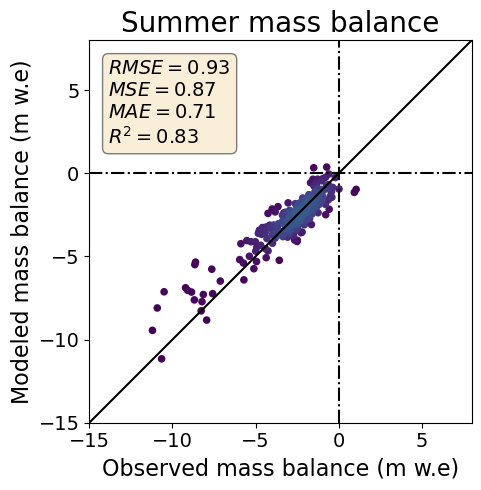

In [121]:
y_val_summer, y_pred_summer = get_prediction_per_season(X_train_s, y_train_s, splits_s_s, best_model, months=5)
y_val_summer_mean, y_pred_summer_agg = get_ytrue_y_pred_agg_season(y_val_summer, y_pred_summer, X_train_s, months=5)
plot_prediction_per_season(y_val_summer_mean, y_pred_summer_agg, season='Summer')

C:\Program Files\Anaconda3\envs\ML_MB_Norway_env\lib\site-packages\xgboost\core.py:160: UserWarning: [11:37:30] WARNING: D:\bld\xgboost-split_1705650032250\work\src\learner.cc:742: 
Parameters: { "metadata_shape" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Program Files\Anaconda3\envs\ML_MB_Norway_env\lib\site-packages\xgboost\core.py:160: UserWarning: [11:37:41] WARNING: D:\bld\xgboost-split_1705650032250\work\src\learner.cc:742: 
Parameters: { "metadata_shape" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Program Files\Anaconda3\envs\ML_MB_Norway_env\lib\site-packages\xgboost\core.py:160: UserWarning: [11:37:52] WARNING: D:\bld\xgboost-split_1705650032250\work\src\learner.cc:742: 
Parameters: { "metadata_shape" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Program Files\Anaconda3\envs\ML_MB_Norway_env\lib\site-packages\xgboost\core.py:160: UserWarning: [11:38:04] WARNING: D:\bld\xgboost-split_1705650032250\work\src\learner.cc:742: 
Parameters: { "metadata

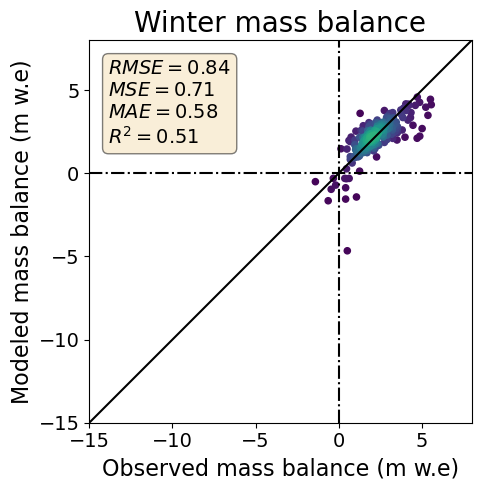

In [122]:
y_val_winter, y_pred_winter = get_prediction_per_season(X_train_s, y_train_s, splits_s_s, best_model, months=7)
y_val_winter_mean, y_pred_winter_agg = get_ytrue_y_pred_agg_season(y_val_winter, y_pred_winter, X_train_s, months=7)
plot_prediction_per_season(y_val_winter_mean, y_pred_winter_agg, season='Winter')

### 4.1 Test model setup: Train model on one fold of full dataset 

In [44]:
# Select fold 0 as training data and fold 1 as validation data
X_train_crop = X_train[fold_indices[0][0],:]
X_val_crop = X_train[fold_indices[0][1],:]
y_train_crop = y_train[fold_indices[0][0]]
y_val_crop = y_train[fold_indices[0][1]]
#X_train_crop = X_train[fold_indices[1][0],:]
#X_val_crop = X_train[fold_indices[1][1],:]
#y_train_crop = y_train[fold_indices[1][0]]
#y_val_crop = y_train[fold_indices[1][1]]

# Check folds
print(X_train_crop.shape)
print(X_val_crop.shape)
print(y_train_crop.shape)
print(y_val_crop.shape)

(46079, 13)
(21830, 13)
(46079, 1)
(21830, 1)


In [37]:
# Define custom XGBRegressor object
xgb_model = CustomXGBRegressor(max_depth=3, learning_rate=0.1, n_estimators=100, gamma=0)

# Fit model for fold 1
xgb_model.fit(X_train_crop, y_train_crop)

C:\Program Files\Anaconda3\envs\ML_MB_Norway_env\lib\site-packages\xgboost\core.py:160: UserWarning: [09:08:19] WARNING: D:\bld\xgboost-split_1705650032250\work\src\learner.cc:742: 
Parameters: { "metadata_shape" } are not used.

  warnings.warn(smsg, UserWarning)


CustomXGBRegressor(base_score=None, booster=None, callbacks=None,
                   colsample_bylevel=None, colsample_bynode=None,
                   colsample_bytree=None, device=None,
                   early_stopping_rounds=None, enable_categorical=False,
                   eval_metric=None, feature_types=None, gamma=0,
                   grow_policy=None, importance_type=None,
                   interaction_constraints=None, learning_rate=0.1,
                   max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
                   max_delta_step=None, max_depth=3, max_leaves=None,
                   min_child_weight=None, missing=nan,
                   monotone_constraints=None, multi_strategy=None,
                   n_estimators=100, n_jobs=None, num_parallel_tree=None,
                   objective=<function CustomXGBRegressor.fit.<locals>.custom_objective at 0x000001BE4E69D240>, ...)

In [67]:
# Save the model to a binary file
#xgb_model.save_model('Models/Custom_loss/xgb_model_fold1_test.bin')

C:\Program Files\Anaconda3\envs\ML_MB_Norway_env\lib\site-packages\xgboost\core.py:160: UserWarning: [16:26:32] WARNING: D:\bld\xgboost-split_1705650032250\work\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)


In [20]:
# Load model
#loaded_model = CustomXGBRegressor()
#loaded_model.load_model('Models/Custom_loss/xgb_model_fold1_test.bin')

In [45]:
# Make predictions on the validation data
predictions = xgb_model.predict(X_val_crop)

In [46]:
# Get validation true values and predictions
y_true_mean, y_pred_agg = get_ytrue_y_pred_agg(y_val_crop,predictions,X_val_crop)

C:\Program Files\Anaconda3\envs\ML_MB_Norway_env\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Program Files\Anaconda3\envs\ML_MB_Norway_env\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


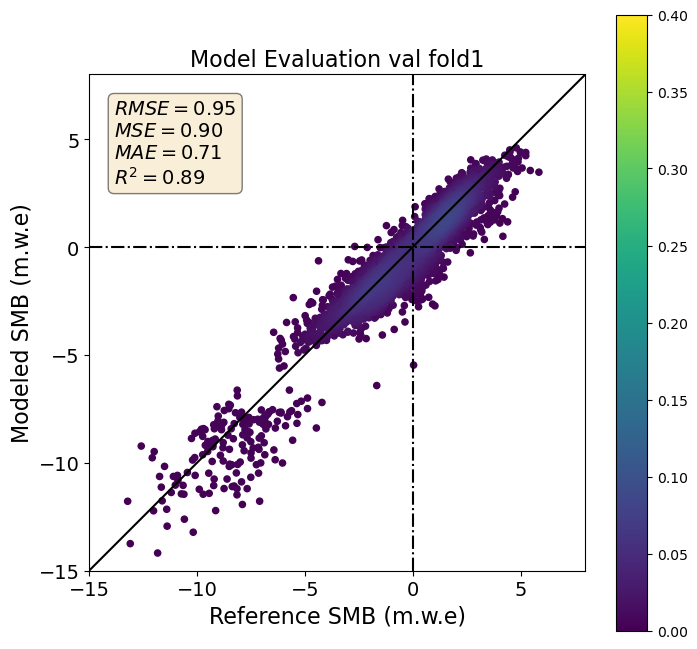

In [47]:
# Plot predictions vs true values for fold 1
plot_prediction(y_true_mean, y_pred_agg, data_type='val fold1')

### 4.2 Full model trained on cluster

In [32]:
# Model trained on cluster using folds split on cycle of years and skyview factor as feature - USING ALL ANNUAL, SUMMER, WINTER DATA
with open('Training_cluster/2024-10-24_10-30-28/custom_loss_cv_grid.pkl', 'rb') as f:
    clf_loaded = pickle.load(f)


In [33]:
clf_loaded.best_estimator_


CustomXGBRegressor(base_score=None, booster=None, callbacks=None,
                   colsample_bylevel=None, colsample_bynode=None,
                   colsample_bytree=None, device=None,
                   early_stopping_rounds=None, enable_categorical=False,
                   eval_metric=None, feature_types=None, gamma=0,
                   grow_policy=None, importance_type=None,
                   interaction_constraints=None, learning_rate=0.05,
                   max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
                   max_delta_step=None, max_depth=5, max_leaves=None,
                   min_child_weight=0, missing=nan, monotone_constraints=None,
                   multi_strategy=None, n_estimators=300, n_jobs=None,
                   num_parallel_tree=None,
                   objective=<function CustomXGBRegressor.fit.<locals>.custom_objective at 0x000001E9CA4A2440>, ...)

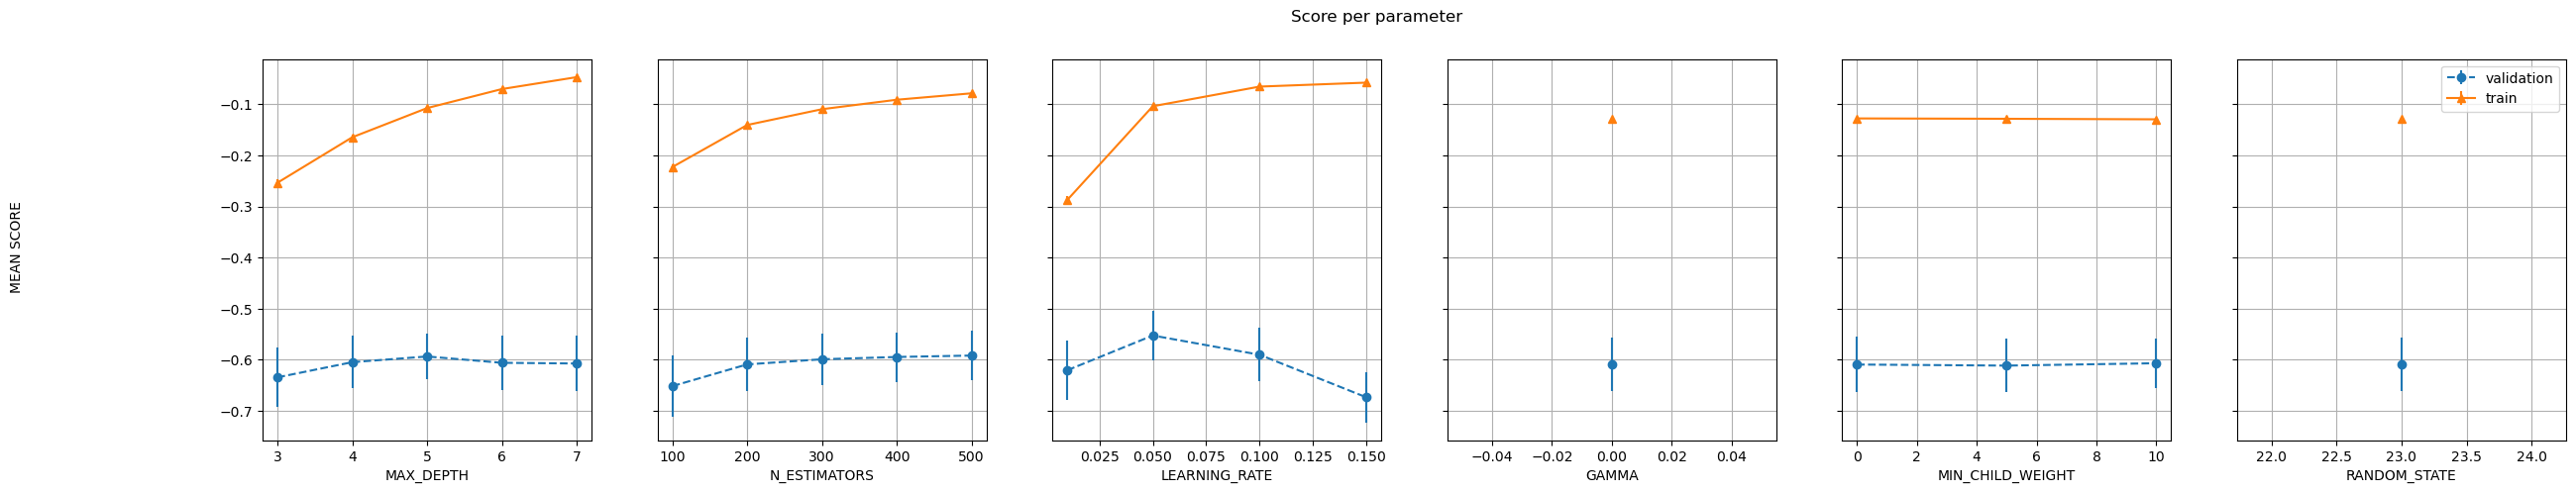

In [34]:
plot_gsearch_results_mod(clf_loaded, learning_rate_threshold=0.15)

In [35]:
cv_results = clf_loaded.cv_results_

results_df = pd.DataFrame({
    'mean_test_score': cv_results['mean_test_score'],
    'params': cv_results['params']
})

sorted_results_df = results_df.sort_values(by='mean_test_score', ascending=False)

# Get the 5 lowest mean test scores and corresponding parameter settings
lowest_5 = sorted_results_df.head(5)

print(lowest_5)

lowest_mean_test_scores = lowest_5['mean_test_score'].values
lowest_parameters = lowest_5['params'].values

print("5 Lowest Mean Test Scores:")
print(lowest_mean_test_scores)

print("\nCorresponding Parameter Settings:")
for params in lowest_parameters:
    print(params)


     mean_test_score                                             params
107        -0.519527  {'gamma': 0, 'learning_rate': 0.05, 'max_depth...
108        -0.521531  {'gamma': 0, 'learning_rate': 0.05, 'max_depth...
109        -0.522960  {'gamma': 0, 'learning_rate': 0.05, 'max_depth...
104        -0.524181  {'gamma': 0, 'learning_rate': 0.05, 'max_depth...
103        -0.524468  {'gamma': 0, 'learning_rate': 0.05, 'max_depth...
5 Lowest Mean Test Scores:
[-0.51952683 -0.52153061 -0.52295998 -0.52418137 -0.52446832]

Corresponding Parameter Settings:
{'gamma': 0, 'learning_rate': 0.05, 'max_depth': 5, 'min_child_weight': 0, 'n_estimators': 300, 'random_state': 23}
{'gamma': 0, 'learning_rate': 0.05, 'max_depth': 5, 'min_child_weight': 0, 'n_estimators': 400, 'random_state': 23}
{'gamma': 0, 'learning_rate': 0.05, 'max_depth': 5, 'min_child_weight': 0, 'n_estimators': 500, 'random_state': 23}
{'gamma': 0, 'learning_rate': 0.05, 'max_depth': 4, 'min_child_weight': 10, 'n_estimators': 500,

C:\Users\kasj\AppData\Local\anaconda3\envs\ML_MB_Norway_envi\lib\site-packages\xgboost\core.py:160: UserWarning: [19:51:00] WARNING: D:\bld\xgboost-split_1705650032250\work\src\learner.cc:742: 
Parameters: { "metadata_shape" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\kasj\AppData\Local\anaconda3\envs\ML_MB_Norway_envi\lib\site-packages\xgboost\core.py:160: UserWarning: [19:51:32] WARNING: D:\bld\xgboost-split_1705650032250\work\src\learner.cc:742: 
Parameters: { "metadata_shape" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\kasj\AppData\Local\anaconda3\envs\ML_MB_Norway_envi\lib\site-packages\xgboost\core.py:160: UserWarning: [19:52:04] WARNING: D:\bld\xgboost-split_1705650032250\work\src\learner.cc:742: 
Parameters: { "metadata_shape" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\kasj\AppData\Local\anaconda3\envs\ML_MB_Norway_envi\lib\site-packages\xgboost\core.py:160: UserWarning: [19:52:36] WARNING: D:\bld\xgboost-split_1705650032250\w

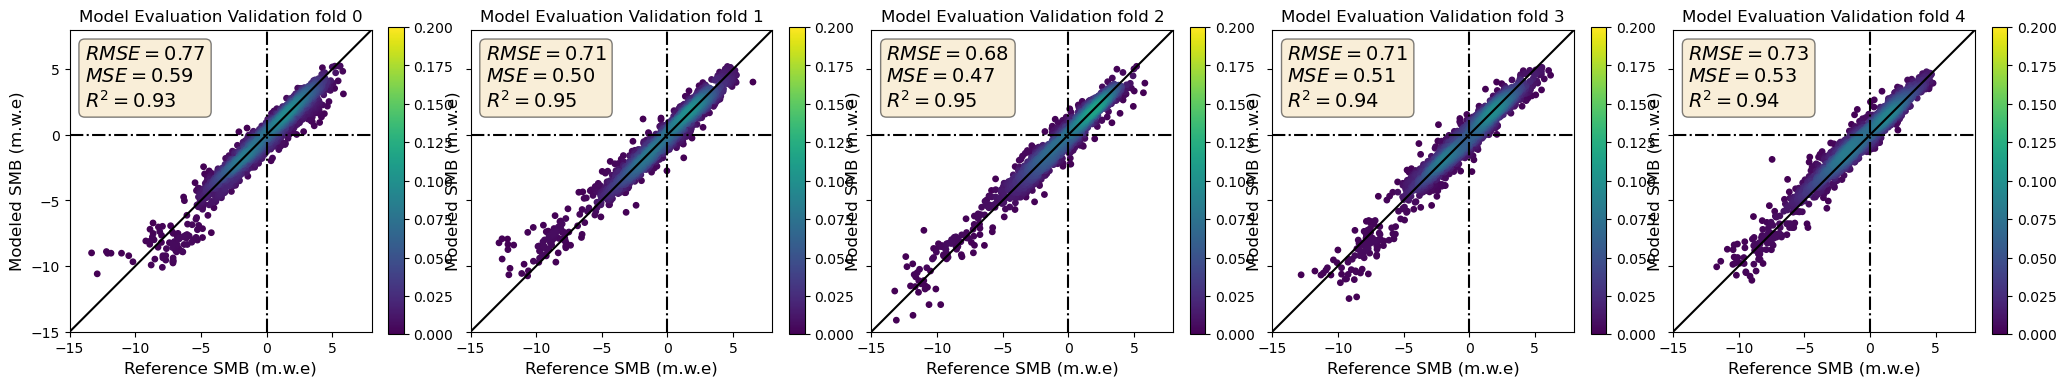

In [38]:
# Evaluate validation performance
from model_classes import custom_mse_metadata

fold_model = clf_loaded.best_estimator_

fig, ax = plt.subplots(1,5, sharex=True, sharey=True, figsize=(25,25))
a = 0    
for train_index, val_index in splits_s:
    # Loops over n_splits iterations and gets train and test splits in each fold
    X_train_, X_val_ = X_train[train_index], X_train[val_index]
    y_train_, y_val_ = y_train[train_index], y_train[val_index]
    fold_model.fit(X_train_, y_train_)
    y_pred = fold_model.predict(X_val_)

    title = 'Validation fold ' + str(a)

    y_val_agg, y_pred_agg = get_ytrue_y_pred_agg(y_val_,y_pred,X_val_)

    plot_prediction_subplot(y_val_agg, y_pred_agg, title, ax[a], n_toplot=5000, fold=True)

    a=a+1

C:\Users\kasj\AppData\Local\anaconda3\envs\ML_MB_Norway_envi\lib\site-packages\xgboost\core.py:160: UserWarning: [15:15:23] WARNING: D:\bld\xgboost-split_1705650032250\work\src\learner.cc:742: 
Parameters: { "metadata_shape" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\kasj\AppData\Local\anaconda3\envs\ML_MB_Norway_envi\lib\site-packages\xgboost\core.py:160: UserWarning: [15:16:11] WARNING: D:\bld\xgboost-split_1705650032250\work\src\learner.cc:742: 
Parameters: { "metadata_shape" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\kasj\AppData\Local\anaconda3\envs\ML_MB_Norway_envi\lib\site-packages\xgboost\core.py:160: UserWarning: [15:16:49] WARNING: D:\bld\xgboost-split_1705650032250\work\src\learner.cc:742: 
Parameters: { "metadata_shape" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\kasj\AppData\Local\anaconda3\envs\ML_MB_Norway_envi\lib\site-packages\xgboost\core.py:160: UserWarning: [15:17:26] WARNING: D:\bld\xgboost-split_1705650032250\w

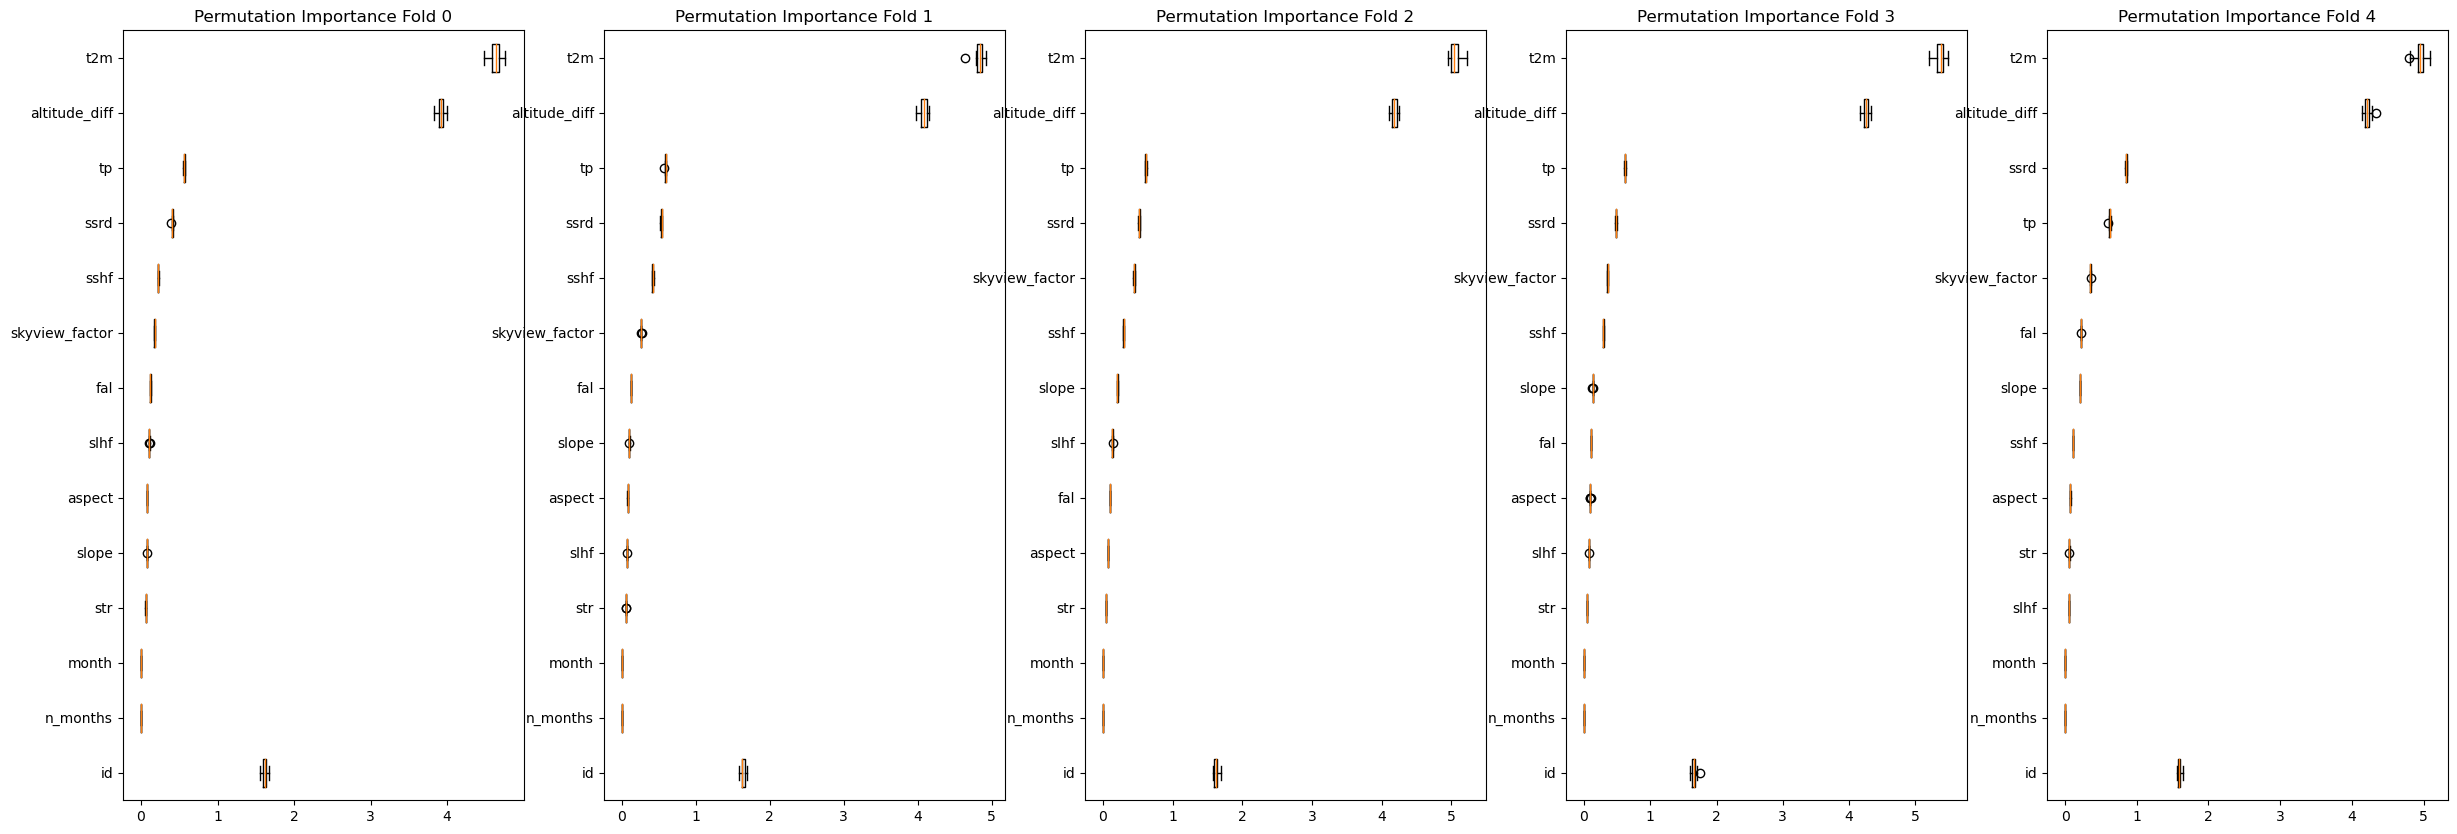

In [174]:
result = plot_permutation_importance_per_fold(df_train_X, X_train, y_train, splits_s, fold_model, max_features_plot = 15)

Text(0.5, 1.0, 'Feature Importance (MDI)')

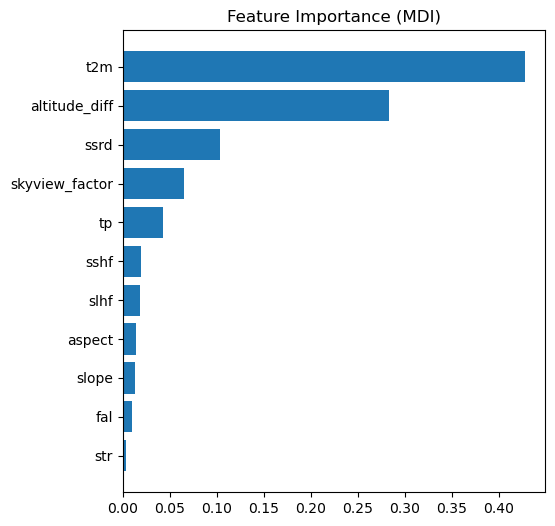

In [175]:
best_model = clf_loaded.best_estimator_

plot_feature_importance(best_model)

In [154]:
#best_model = clf_loaded.best_estimator_
#best_model.fit(X_train, y_train)
best_model = CustomXGBRegressor(max_depth=7, learning_rate=0.1, gamma=10, n_estimators=800)
best_model.fit(X_train, y_train)

C:\Program Files\Anaconda3\envs\ML_MB_Norway_env\lib\site-packages\xgboost\core.py:160: UserWarning: [16:28:12] WARNING: D:\bld\xgboost-split_1705650032250\work\src\learner.cc:742: 
Parameters: { "metadata_shape" } are not used.

  warnings.warn(smsg, UserWarning)


CustomXGBRegressor(base_score=None, booster=None, callbacks=None,
                   colsample_bylevel=None, colsample_bynode=None,
                   colsample_bytree=None, device=None,
                   early_stopping_rounds=None, enable_categorical=False,
                   eval_metric=None, feature_types=None, gamma=10,
                   grow_policy=None, importance_type=None,
                   interaction_constraints=None, learning_rate=0.1,
                   max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
                   max_delta_step=None, max_depth=7, max_leaves=None,
                   min_child_weight=None, missing=nan,
                   monotone_constraints=None, multi_strategy=None,
                   n_estimators=800, n_jobs=None, num_parallel_tree=None,
                   objective=<function CustomXGBRegressor.fit.<locals>.custom_objective at 0x000002C38B292680>, ...)

C:\Program Files\Anaconda3\envs\ML_MB_Norway_env\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Program Files\Anaconda3\envs\ML_MB_Norway_env\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


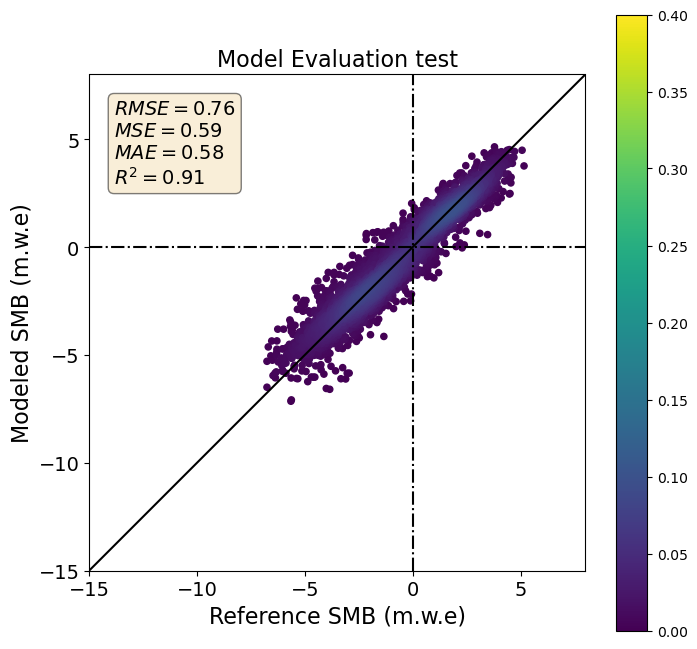

In [155]:
test_pred = best_model.predict(X_test)

# Get test true values and predictions
y_test_mean, y_test_pred_agg = get_ytrue_y_pred_agg(y_test,test_pred,X_test)

# Plot predictions vs true values for test
plot_prediction(y_test_mean, y_test_pred_agg, data_type='test')

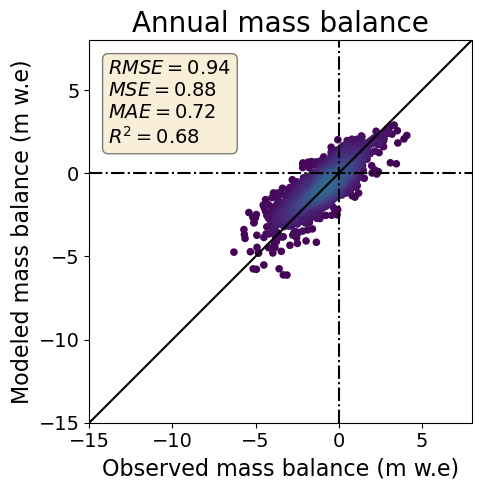

In [156]:
y_test_annual, y_pred_annual = get_prediction_per_season_test(X_test, y_test, best_model, months=12)
annual_indices = X_test[:, -2] == 12
X_test_annual = X_test[annual_indices]
y_test_annual_mean, y_pred_annual_agg = get_ytrue_y_pred_agg_season(y_test_annual, y_pred_annual, X_test_annual, months=12)
plot_prediction_per_season(y_test_annual_mean, y_pred_annual_agg, season='Annual')

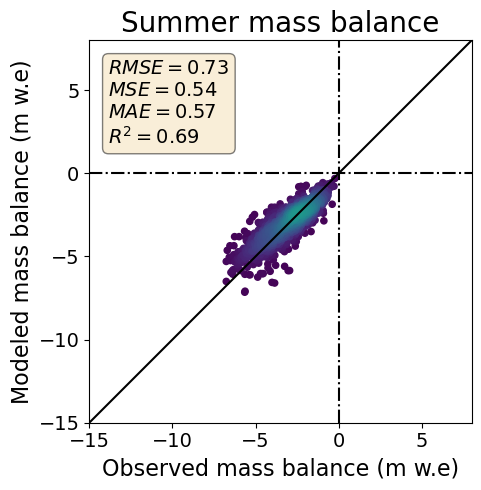

In [157]:
y_test_summer, y_pred_summer = get_prediction_per_season_test(X_test, y_test, best_model, months=5)
summer_indices = X_test[:, -2] == 5
X_test_summer = X_test[summer_indices]
y_test_summer_mean, y_pred_summer_agg = get_ytrue_y_pred_agg_season(y_test_summer, y_pred_summer, X_test_summer, months=5)
plot_prediction_per_season(y_test_summer_mean, y_pred_summer_agg, season='Summer')

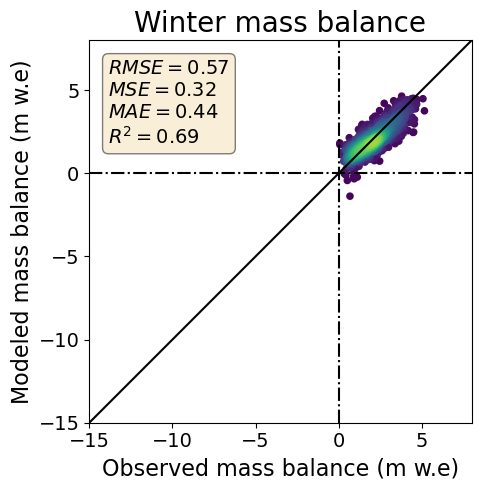

In [158]:
y_test_winter, y_pred_winter = get_prediction_per_season_test(X_test, y_test, best_model, months=7)
winter_indices = X_test[:, -2] == 7
X_test_winter = X_test[winter_indices]
y_test_winter_mean, y_pred_winter_agg = get_ytrue_y_pred_agg_season(y_test_winter, y_pred_winter, X_test_winter, months=7)
plot_prediction_per_season(y_test_winter_mean, y_pred_winter_agg, season='Winter')

In [196]:
best_model = clf_loaded.best_estimator_
best_model.fit(X_train, y_train)

C:\Program Files\Anaconda3\envs\ML_MB_Norway_env\lib\site-packages\xgboost\core.py:160: UserWarning: [12:01:34] WARNING: D:\bld\xgboost-split_1705650032250\work\src\learner.cc:742: 
Parameters: { "metadata_shape" } are not used.

  warnings.warn(smsg, UserWarning)


CustomXGBRegressor(base_score=None, booster=None, callbacks=None,
                   colsample_bylevel=None, colsample_bynode=None,
                   colsample_bytree=None, device=None,
                   early_stopping_rounds=None, enable_categorical=False,
                   eval_metric=None, feature_types=None, gamma=None,
                   grow_policy=None, importance_type=None,
                   interaction_constraints=None, learning_rate=0.1,
                   max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
                   max_delta_step=None, max_depth=7, max_leaves=None,
                   min_child_weight=None, missing=nan,
                   monotone_constraints=None, multi_strategy=None,
                   n_estimators=700, n_jobs=None, num_parallel_tree=None,
                   objective=<function CustomXGBRegressor.fit.<locals>.custom_objective at 0x0000024F61E751B0>, ...)

C:\Program Files\Anaconda3\envs\ML_MB_Norway_env\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Program Files\Anaconda3\envs\ML_MB_Norway_env\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


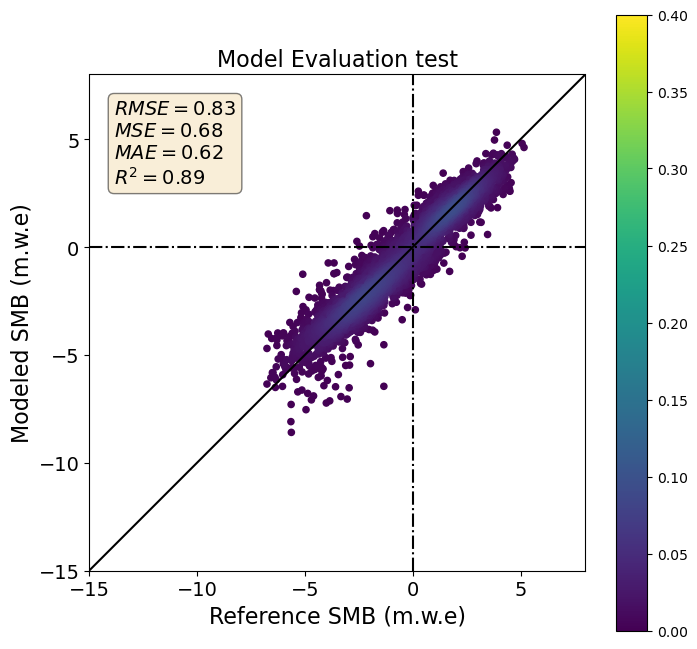

In [199]:
test_pred = best_model.predict(X_test)

# Get test true values and predictions
y_test_mean, y_test_pred_agg = get_ytrue_y_pred_agg(y_test,test_pred,X_test)

# Plot predictions vs true values for test
plot_prediction(y_test_mean, y_test_pred_agg, data_type='test')

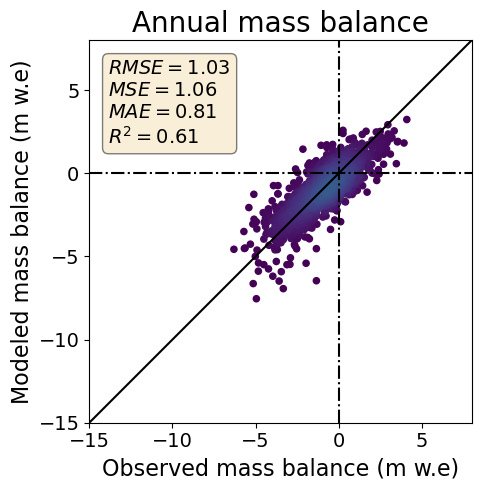

In [200]:
y_test_annual, y_pred_annual = get_prediction_per_season_test(X_test, y_test, best_model, months=12)
annual_indices = X_test[:, -2] == 12
X_test_annual = X_test[annual_indices]
y_test_annual_mean, y_pred_annual_agg = get_ytrue_y_pred_agg_season(y_test_annual, y_pred_annual, X_test_annual, months=12)
plot_prediction_per_season(y_test_annual_mean, y_pred_annual_agg, season='Annual')

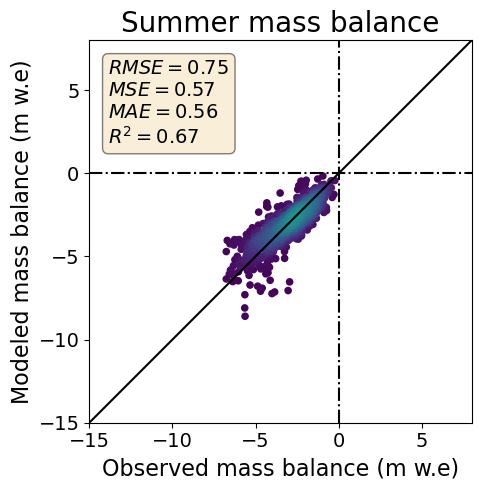

In [201]:
y_test_summer, y_pred_summer = get_prediction_per_season_test(X_test, y_test, best_model, months=5)
summer_indices = X_test[:, -2] == 5
X_test_summer = X_test[summer_indices]
y_test_summer_mean, y_pred_summer_agg = get_ytrue_y_pred_agg_season(y_test_summer, y_pred_summer, X_test_summer, months=5)
plot_prediction_per_season(y_test_summer_mean, y_pred_summer_agg, season='Summer')

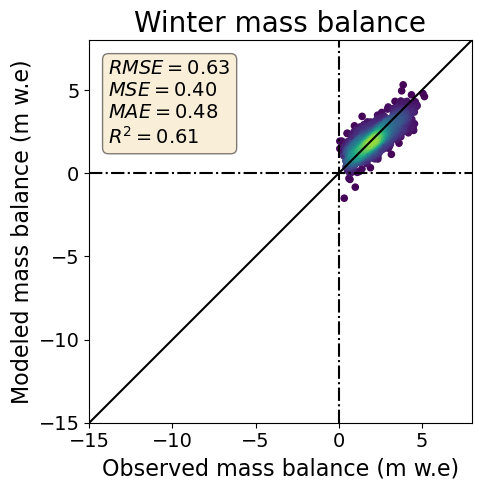

In [202]:
y_test_winter, y_pred_winter = get_prediction_per_season_test(X_test, y_test, best_model, months=7)
winter_indices = X_test[:, -2] == 7
X_test_winter = X_test[winter_indices]
y_test_winter_mean, y_pred_winter_agg = get_ytrue_y_pred_agg_season(y_test_winter, y_pred_winter, X_test_winter, months=7)
plot_prediction_per_season(y_test_winter_mean, y_pred_winter_agg, season='Winter')